# Analysing FEMA's National Flood Insurance Program (NFIP) Data Using Python

In [310]:
# importing libraries
import pandas as pd # the pd is by convention
import numpy as np # as is the np
import geopandas as gpd
from geopandas.tools import overlay
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pylab as pl 
import shapely
from fiona.crs import from_epsg
import urllib
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates



# to Plot matplotlib figures inline on the notebook
%matplotlib inline

In [2]:
# changing directories to Downloads folder
%cd ~/Downloads/

/Users/geribauer/Downloads


In [3]:
# dowloading the data with urllib.request.urlretrieve()
url = 'https://www.fema.gov/media-library-data/1575491579309-2366ee38d902c1bc983370e132ee36cc/FIMA_NFIP_Redacted_Claims_Data_Set.zip'

# retrieving the file and naming it as 'nfip_claims.gz'
urllib.request.urlretrieve(url, "nfip_claims_year.gz")

('nfip_claims_year.gz', <http.client.HTTPMessage at 0x1a19f92438>)

In [4]:
# unzipping the file
!unzip -d ~/Downloads/ nfip_claims_year.gz

Archive:  nfip_claims_year.gz
  inflating: /Users/geribauer/Downloads/NFIP Claims Instructions and Metadata.xlsx  
  inflating: /Users/geribauer/Downloads/openFEMA_claims20190831.csv  


In [5]:
# moving the metadata into our nyc project data folder
%mv 'NFIP Claims Instructions and Metadata.xlsx' ~/'fema-nfip-claims/nfip-claims-national/data-dictionary/NFIP-claims-instructions-and-metadata.xlsx'

In [6]:
%cd ~/'fema-nfip-claims/nfip-claims-national/data-dictionary'
%ls

/Users/geribauer/fema-nfip-claims/nfip-claims-national/data-dictionary
NFIP-claims-instructions-and-metadata.xlsx*


In [255]:
# changing directories to Downloads folder
%cd ~/Downloads/

/Users/geribauer/Downloads


In [256]:
# read our data into a DataFrame
nfip_claims = pd.read_csv('openFEMA_claims20190831.csv')

In [257]:
nfip_claims.head()

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,...,amountpaidonincreasedcostofcomplianceclaim,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,reportedzipcode,primaryresidence
0,NaN,2019-08-31,NaN,0.0,OCEANSIDE,N,1.0,6073.0,0.00,1998-02-07,...,NaN,N,7,NaN,CA,200000.0,50000.0,1998,92056,NaN
1,NaN,2019-08-31,NaN,0.0,NEW ORLEANS,N,1.0,22071.0,0.00,2005-08-29,...,NaN,N,7,NaN,LA,100000.0,40000.0,2005,70131,Y
2,NaN,2019-08-31,NaN,0.0,NAVARRE,N,1.0,12113.0,0.05,1998-09-28,...,0.0,N,1,NaN,FL,100000.0,50000.0,1998,32566,NaN
3,NaN,2019-08-31,NaN,1.0,BEAUFORT,N,1.0,45013.0,0.00,1994-10-07,...,NaN,N,7,NaN,SC,100000.0,25000.0,1994,29902,NaN
4,NaN,2019-08-31,NaN,0.0,MELBOURNE,N,1.0,12009.0,0.00,1996-03-11,...,NaN,Y,7,NaN,FL,100000.0,25000.0,1996,32940,NaN


In [258]:
print('This dataset is as of', nfip_claims.asofdate[0], "from FEMA's Open Data Portal.")

This dataset is as of 2019-08-31 from FEMA's Open Data Portal.


In [259]:
%cd ~/fema-nfip-claims/nfip-claims-national

/Users/geribauer/fema-nfip-claims/nfip-claims-national


In [260]:
nfip_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432888 entries, 0 to 2432887
Data columns (total 39 columns):
agriculturestructureindicator                 object
asofdate                                      object
basefloodelevation                            float64
basementenclosurecrawlspacetype               float64
reportedcity                                  object
condominiumindicator                          object
policycount                                   float64
countycode                                    float64
crsdiscount                                   float64
dateofloss                                    object
elevatedbuildingindicator                     object
elevationcertificateindicator                 object
elevationdifference                           float64
censustract                                   float64
floodzone                                     object
houseworship                                  object
latitude                        

In [261]:
nfip_claims.describe()

,basefloodelevation,basementenclosurecrawlspacetype,policycount,countycode,crsdiscount,elevationdifference,censustract,latitude,longitude,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,occupancytype,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss
count,483589.000000,2.432843e+06,2.432880e+06,2.425385e+06,2.432880e+06,2.432880e+06,2.373588e+06,2.379340e+06,2.379340e+06,350723.000000,475071.000000,2.416237e+06,2.432168e+06,2.359510e+06,1.712987e+06,1.160371e+06,2.432880e+06,2.432880e+06,2.432888e+06
mean,71.378912,4.672303e-01,1.247610e+00,3.020189e+04,3.494819e-02,7.505239e+02,3.004539e+10,3.404449e+01,-8.614260e+01,75.457087,148.298637,1.722882e+00,1.404049e+00,2.367499e+04,7.729023e+03,7.600233e+02,1.512794e+05,2.819080e+04,2.000633e+03
std,300.583343,9.312251e-01,6.239860e+00,1.456152e+04,6.239606e-02,4.321235e+02,1.445356e+10,5.801293e+00,1.111013e+01,546.574281,980.141421,8.858817e-01,9.672842e-01,5.278161e+04,2.280169e+04,4.441656e+03,2.777121e+06,4.809394e+04,1.179710e+01
min,-6002.000000,0.000000e+00,1.000000e+00,1.001000e+03,0.000000e+00,-1.987000e+03,1.003000e+03,-1.430000e+01,-1.707000e+02,-3411.000000,-6002.000000,1.000000e+00,1.000000e+00,-2.920705e+04,-8.484000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.970000e+03
25%,7.000000,0.000000e+00,1.000000e+00,2.201900e+04,0.000000e+00,9.990000e+02,2.201900e+10,2.990000e+01,-9.140000e+01,3.200000,6.500000,1.000000e+00,1.000000e+00,1.085800e+02,0.000000e+00,0.000000e+00,3.500000e+04,0.000000e+00,1.992000e+03
50%,9.000000,0.000000e+00,1.000000e+00,2.916300e+04,0.000000e+00,9.990000e+02,2.912796e+10,3.190000e+01,-8.750000e+01,6.700000,10.300000,1.000000e+00,1.000000e+00,4.818810e+03,2.290000e+02,0.000000e+00,9.080000e+04,1.050000e+04,2.004000e+03
75%,14.000000,0.000000e+00,1.000000e+00,4.207500e+04,5.000000e-02,9.990000e+02,4.206195e+10,3.990000e+01,-7.690000e+01,12.900000,17.800000,2.000000e+00,1.000000e+00,2.402774e+04,5.830405e+03,0.000000e+00,1.950000e+05,4.000000e+04,2.011000e+03
max,9998.000000,4.000000e+00,1.090000e+03,7.803000e+04,4.000000e-01,9.998000e+03,7.803096e+10,6.990000e+01,1.449000e+02,99999.100000,99999.900000,6.000000e+00,6.000000e+00,1.000000e+07,7.500000e+05,6.000000e+04,4.000000e+09,6.000000e+06,2.019000e+03


In [262]:
nfip_claims.iloc[:,:15].head()

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,elevatedbuildingindicator,elevationcertificateindicator,elevationdifference,censustract,floodzone
0,NaN,2019-08-31,NaN,0.0,OCEANSIDE,N,1.0,6073.0,0.00,1998-02-07,N,NaN,999.0,6.073019e+09,X
1,NaN,2019-08-31,NaN,0.0,NEW ORLEANS,N,1.0,22071.0,0.00,2005-08-29,N,NaN,999.0,2.207100e+10,X
2,NaN,2019-08-31,NaN,0.0,NAVARRE,N,1.0,12113.0,0.05,1998-09-28,N,NaN,999.0,1.211301e+10,X
3,NaN,2019-08-31,NaN,1.0,BEAUFORT,N,1.0,45013.0,0.00,1994-10-07,N,NaN,999.0,4.501300e+10,X
4,NaN,2019-08-31,NaN,0.0,MELBOURNE,N,1.0,12009.0,0.00,1996-03-11,N,NaN,999.0,1.200906e+10,X


In [263]:
nfip_claims.iloc[:,15:30].head()

,houseworship,latitude,locationofcontents,longitude,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,nonprofitindicator,obstructiontype,occupancytype,originalconstructiondate,originalnbdate,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim
0,NaN,33.2,NaN,-117.3,NaN,NaN,4.0,NaN,10,1.0,1963-01-01,1997-01-11,0.00,0.0,NaN
1,NaN,29.9,NaN,-90.0,NaN,NaN,2.0,NaN,10,1.0,1967-07-01,1990-07-12,0.00,0.0,NaN
2,NaN,30.4,NaN,-86.9,NaN,NaN,1.0,NaN,10,1.0,1972-01-01,1997-07-24,8813.21,1720.0,0.0
3,NaN,32.4,NaN,-80.7,NaN,NaN,2.0,NaN,10,1.0,1960-01-01,1993-10-01,2906.00,0.0,NaN
4,NaN,28.3,NaN,-80.7,NaN,NaN,1.0,NaN,10,1.0,1988-01-01,1996-01-11,3875.53,1545.0,NaN


In [264]:
nfip_claims.iloc[:,30:].head()

,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,reportedzipcode,primaryresidence
0,N,7,NaN,CA,200000.0,50000.0,1998,92056,NaN
1,N,7,NaN,LA,100000.0,40000.0,2005,70131,Y
2,N,1,NaN,FL,100000.0,50000.0,1998,32566,NaN
3,N,7,NaN,SC,100000.0,25000.0,1994,29902,NaN
4,Y,7,NaN,FL,100000.0,25000.0,1996,32940,NaN


In [265]:
nfip_claims.yearofloss.unique()

array([1998, 2005, 1994, 1996, 2017, 1992, 1995, 2008, 1999, 2003, 2004,
       1989, 1997, 2009, 1991, 2015, 1993, 2012, 2010, 2000, 2002, 2011,
       2001, 2006, 2018, 1985, 2014, 2013, 2007, 1986, 1988, 1987, 2016,
       1990, 2019, 1984, 1983, 1981, 1979, 1978, 1980, 1982, 1977, 1976,
       1975, 1974, 1973, 1970, 1972])

In [266]:
nfip_claims = nfip_claims.loc[nfip_claims.yearofloss > 1977]

In [267]:
nfip_claims.yearofloss.unique()

array([1998, 2005, 1994, 1996, 2017, 1992, 1995, 2008, 1999, 2003, 2004,
       1989, 1997, 2009, 1991, 2015, 1993, 2012, 2010, 2000, 2002, 2011,
       2001, 2006, 2018, 1985, 2014, 2013, 2007, 1986, 1988, 1987, 2016,
       1990, 2019, 1984, 1983, 1981, 1979, 1978, 1980, 1982])

In [268]:
nfip_claims.shape

(2427080, 39)

In [269]:
nfip_claims.head()

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,...,amountpaidonincreasedcostofcomplianceclaim,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,reportedzipcode,primaryresidence
0,NaN,2019-08-31,NaN,0.0,OCEANSIDE,N,1.0,6073.0,0.00,1998-02-07,...,NaN,N,7,NaN,CA,200000.0,50000.0,1998,92056,NaN
1,NaN,2019-08-31,NaN,0.0,NEW ORLEANS,N,1.0,22071.0,0.00,2005-08-29,...,NaN,N,7,NaN,LA,100000.0,40000.0,2005,70131,Y
2,NaN,2019-08-31,NaN,0.0,NAVARRE,N,1.0,12113.0,0.05,1998-09-28,...,0.0,N,1,NaN,FL,100000.0,50000.0,1998,32566,NaN
3,NaN,2019-08-31,NaN,1.0,BEAUFORT,N,1.0,45013.0,0.00,1994-10-07,...,NaN,N,7,NaN,SC,100000.0,25000.0,1994,29902,NaN
4,NaN,2019-08-31,NaN,0.0,MELBOURNE,N,1.0,12009.0,0.00,1996-03-11,...,NaN,Y,7,NaN,FL,100000.0,25000.0,1996,32940,NaN


In [270]:
# adding a new column called 'amountpaidontotalclaim' that adds both building and contents claim to get the total claim

nfip_claims['amountpaidontotalclaim'] = nfip_claims['amountpaidonbuildingclaim'] + nfip_claims['amountpaidoncontentsclaim']

In [271]:
nfip_claims[['amountpaidonbuildingclaim', 'amountpaidoncontentsclaim', 'amountpaidontotalclaim']].head()

,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidontotalclaim
0,0.00,0.0,0.00
1,0.00,0.0,0.00
2,8813.21,1720.0,10533.21
3,2906.00,0.0,2906.00
4,3875.53,1545.0,5420.53


## Group by Claim Count

In [272]:
# grouping dataframe by 'Year' and counting values of columns
nfip_claims_year_count = nfip_claims.groupby('yearofloss').count()

In [273]:
nfip_claims_year_count.head(10)

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,...,amountpaidonincreasedcostofcomplianceclaim,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,reportedzipcode,primaryresidence,amountpaidontotalclaim
yearofloss,,,,,,,,,,,,,,,,,,,,,
1978,0,35897,2114,35897,35637,2161,35897,35653,35897,35897,...,0,2161,2161,0,35897,35897,35897,35892,0,24553
1979,0,87375,7092,87375,86613,75790,87375,86377,87375,87375,...,0,75838,75838,0,87375,87375,87375,87368,0,61547
1980,0,53227,5199,53227,52817,52651,53227,52627,53227,53227,...,0,52729,52729,0,53227,53227,53227,53223,0,37998
1981,0,31178,2103,31178,30863,30493,31178,30473,31178,31178,...,0,30608,30608,0,31178,31178,31178,31147,0,20552
1982,0,43118,3617,43118,42623,41906,43118,42337,43118,43118,...,0,42430,42430,0,43118,43118,43118,43097,0,30073
1983,0,70474,7143,70474,69776,69080,70474,69318,70474,70474,...,0,69506,69506,0,70474,70474,70474,70412,0,52062
1984,0,39236,4516,39236,38882,38213,39236,38505,39236,39236,...,0,38573,38574,0,39236,39236,39236,39174,0,26987
1985,0,52339,6108,52338,51563,51407,52338,51812,52338,52339,...,0,51829,51833,0,52338,52338,52338,51990,5,38061
1986,0,18863,808,18863,18655,18692,18863,18711,18863,18863,...,0,18716,18717,0,18863,18863,18863,18707,2,12193


In [274]:
nfip_claims_year_count[['asofdate']].head()

,asofdate
yearofloss,
1978,35897
1979,87375
1980,53227
1981,31178
1982,43118


In [275]:
nfip_claims_year_count.rename(columns={"asofdate": "claimscount"}, inplace=True)

In [276]:
nfip_claims_year_count[['claimscount']].head()

,claimscount
yearofloss,
1978,35897
1979,87375
1980,53227
1981,31178
1982,43118


In [277]:
nfip_claims_year_count = nfip_claims_year_count[['claimscount']]

In [278]:
nfip_claims_year_count.head()

,claimscount
yearofloss,
1978,35897
1979,87375
1980,53227
1981,31178
1982,43118


In [279]:
nfip_claims_year_count.shape

(42, 1)

In [280]:
nfip_claims_year_count.claimscount.sum()

2427080

## Group by Claim Dollar Amount

In [281]:
nfip_claims_year_amount = nfip_claims.groupby('yearofloss').sum()

In [282]:
nfip_claims_year_amount.head()

,basefloodelevation,basementenclosurecrawlspacetype,policycount,countycode,crsdiscount,elevationdifference,censustract,latitude,longitude,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,occupancytype,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,amountpaidontotalclaim
yearofloss,,,,,,,,,,,,,,,,,,,
1978,422833.0,97914.0,35897.0,1.053068e+09,0.0,34274814.0,9.924704e+14,1259116.0,-2.881926e+06,0.0,318803.0,83188.0,52888.0,1.003986e+08,4.732061e+07,0.0,8.397963e+08,275182700.0,1.112615e+08
1979,724576.0,73158.0,87375.0,2.925253e+09,0.0,83496791.0,2.709387e+15,2786737.4,-6.893635e+06,0.0,234197.0,148872.0,128734.0,3.335841e+08,1.496971e+08,0.0,2.303435e+09,719389000.0,3.833123e+08
1980,191338.0,36431.0,53227.0,1.524301e+09,0.0,49691335.0,1.434188e+15,1688629.7,-4.446409e+06,0.0,77721.6,96121.0,79292.0,1.563893e+08,7.402499e+07,0.0,1.550755e+09,486405300.0,1.788658e+08
1981,350002.1,22566.0,31178.0,1.069061e+09,0.0,29797235.0,9.729137e+14,959053.3,-2.528679e+06,0.0,117444.1,54490.0,47946.0,8.045642e+07,4.667716e+07,0.0,1.083387e+09,356951300.0,9.609555e+07
1982,613063.8,32659.0,43118.0,1.044492e+09,0.0,41270953.0,9.221404e+14,1346455.1,-3.362269e+06,0.0,306518.8,76974.0,64716.0,1.316847e+08,6.663998e+07,0.0,1.472250e+09,436089900.0,1.505118e+08


In [283]:
nfip_claims_year_amount[['amountpaidontotalclaim']].head()

,amountpaidontotalclaim
yearofloss,
1978,1.112615e+08
1979,3.833123e+08
1980,1.788658e+08
1981,9.609555e+07
1982,1.505118e+08


In [284]:
nfip_claims_year_amount = nfip_claims_year_amount[['amountpaidontotalclaim']]

In [285]:
nfip_claims_year_amount.head()

,amountpaidontotalclaim
yearofloss,
1978,1.112615e+08
1979,3.833123e+08
1980,1.788658e+08
1981,9.609555e+07
1982,1.505118e+08


## Join dataframes (i.e count and claim dollar amount)

In [286]:
nfip_claims_year_count.reset_index(inplace=True)
nfip_claims_year_count.head()

,yearofloss,claimscount
0,1978,35897
1,1979,87375
2,1980,53227
3,1981,31178
4,1982,43118


In [287]:
nfip_claims_year_amount.reset_index(inplace=True)
nfip_claims_year_amount.head()

,yearofloss,amountpaidontotalclaim
0,1978,1.112615e+08
1,1979,3.833123e+08
2,1980,1.788658e+08
3,1981,9.609555e+07
4,1982,1.505118e+08


In [288]:
nfip_claims_year = nfip_claims_year_count.merge(nfip_claims_year_amount, left_on="yearofloss", 
              right_on="yearofloss")

In [289]:
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim
0,1978,35897,1.112615e+08
1,1979,87375,3.833123e+08
2,1980,53227,1.788658e+08
3,1981,31178,9.609555e+07
4,1982,43118,1.505118e+08


In [290]:
nfip_claims_year['average_paid_flood_claim'] = nfip_claims_year['amountpaidontotalclaim'] / nfip_claims_year['claimscount']

In [291]:
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,1978,35897,1.112615e+08,3099.464842
1,1979,87375,3.833123e+08,4386.979364
2,1980,53227,1.788658e+08,3360.432944
3,1981,31178,9.609555e+07,3082.158858
4,1982,43118,1.505118e+08,3490.696376


In [292]:
nfip_claims_year.round({'average_paid_flood_claim': 2}).head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,1978,35897,1.112615e+08,3099.46
1,1979,87375,3.833123e+08,4386.98
2,1980,53227,1.788658e+08,3360.43
3,1981,31178,9.609555e+07,3082.16
4,1982,43118,1.505118e+08,3490.70


In [293]:
nfip_claims_year = nfip_claims_year.round({'average_paid_flood_claim': 2})

In [294]:
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,1978,35897,1.112615e+08,3099.46
1,1979,87375,3.833123e+08,4386.98
2,1980,53227,1.788658e+08,3360.43
3,1981,31178,9.609555e+07,3082.16
4,1982,43118,1.505118e+08,3490.70


## Formatting to create timeseries plot

In [295]:
# setting index to 'dateofloss' column
nfip_claims_year.set_index('yearofloss', drop=False, inplace=True)
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
yearofloss,,,,
1978,1978,35897,1.112615e+08,3099.46
1979,1979,87375,3.833123e+08,4386.98
1980,1980,53227,1.788658e+08,3360.43
1981,1981,31178,9.609555e+07,3082.16
1982,1982,43118,1.505118e+08,3490.70


In [296]:
# transforming our 'Year' index to datetime
nfip_claims_year.index = pd.to_datetime(nfip_claims_year.index, format='%Y')

In [304]:
nfip_claims_year.index.dtype

dtype('<M8[ns]')

In [312]:
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
yearofloss,,,,
1978-01-01,1978,35897,1.112615e+08,3099.46
1979-01-01,1979,87375,3.833123e+08,4386.98
1980-01-01,1980,53227,1.788658e+08,3360.43
1981-01-01,1981,31178,9.609555e+07,3082.16
1982-01-01,1982,43118,1.505118e+08,3490.70


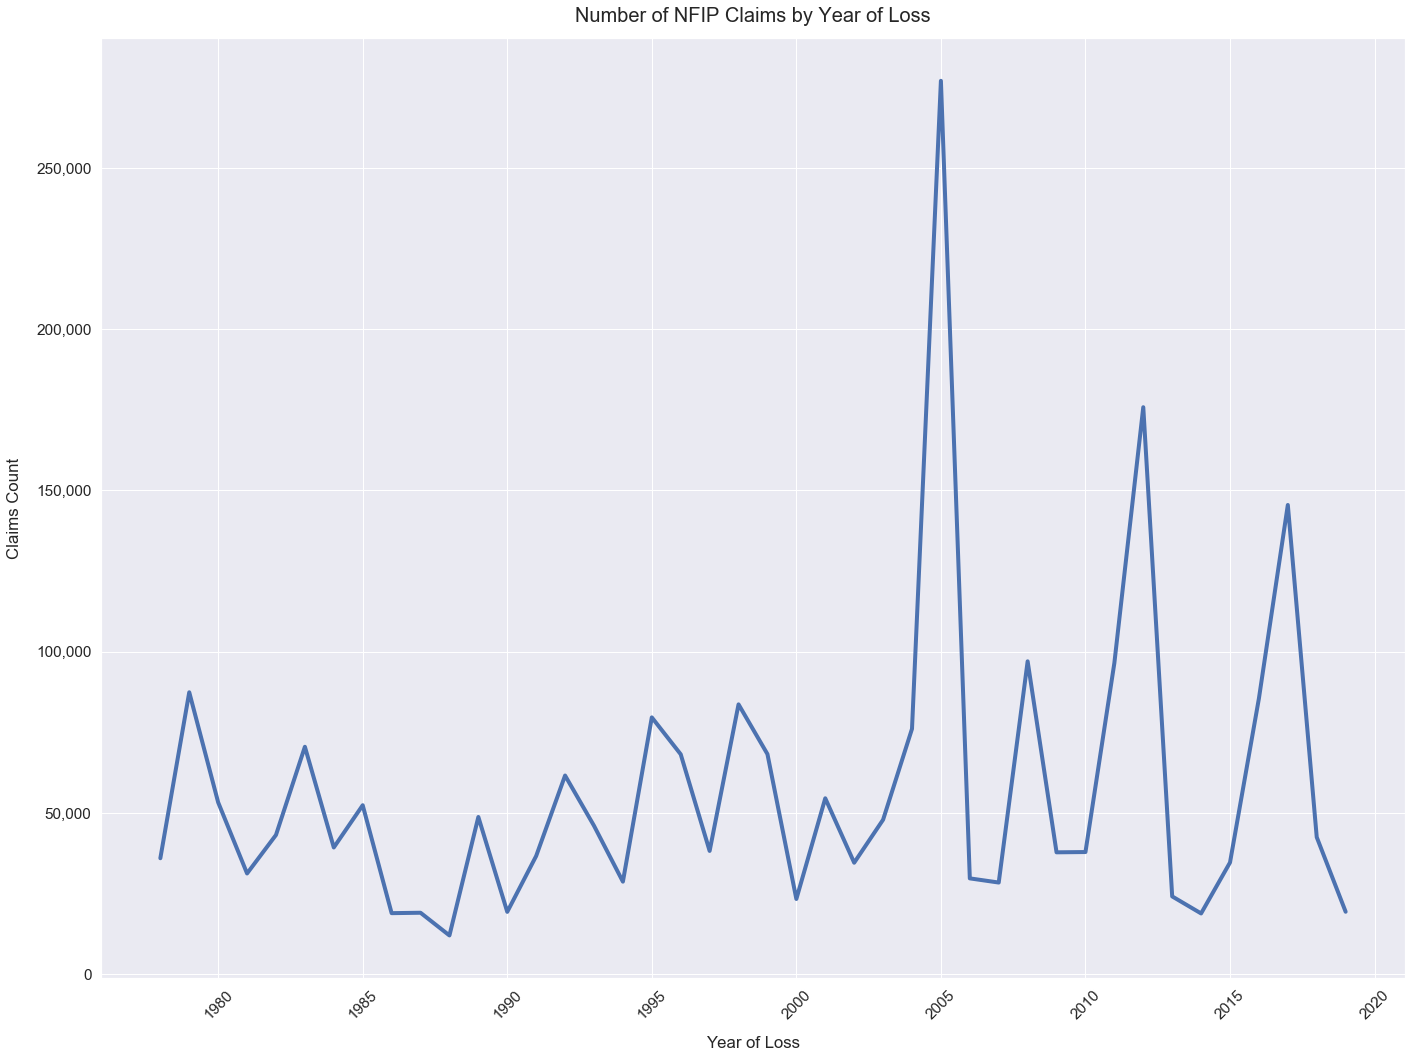

In [319]:
years = mdates.YearLocator(5)   # every 5 year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# plotting bar chart of number of claims by year
nfip_claims_year['claimscount'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Number of NFIP Claims by Year of Loss", pad=16, fontsize=20)

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-count.png')

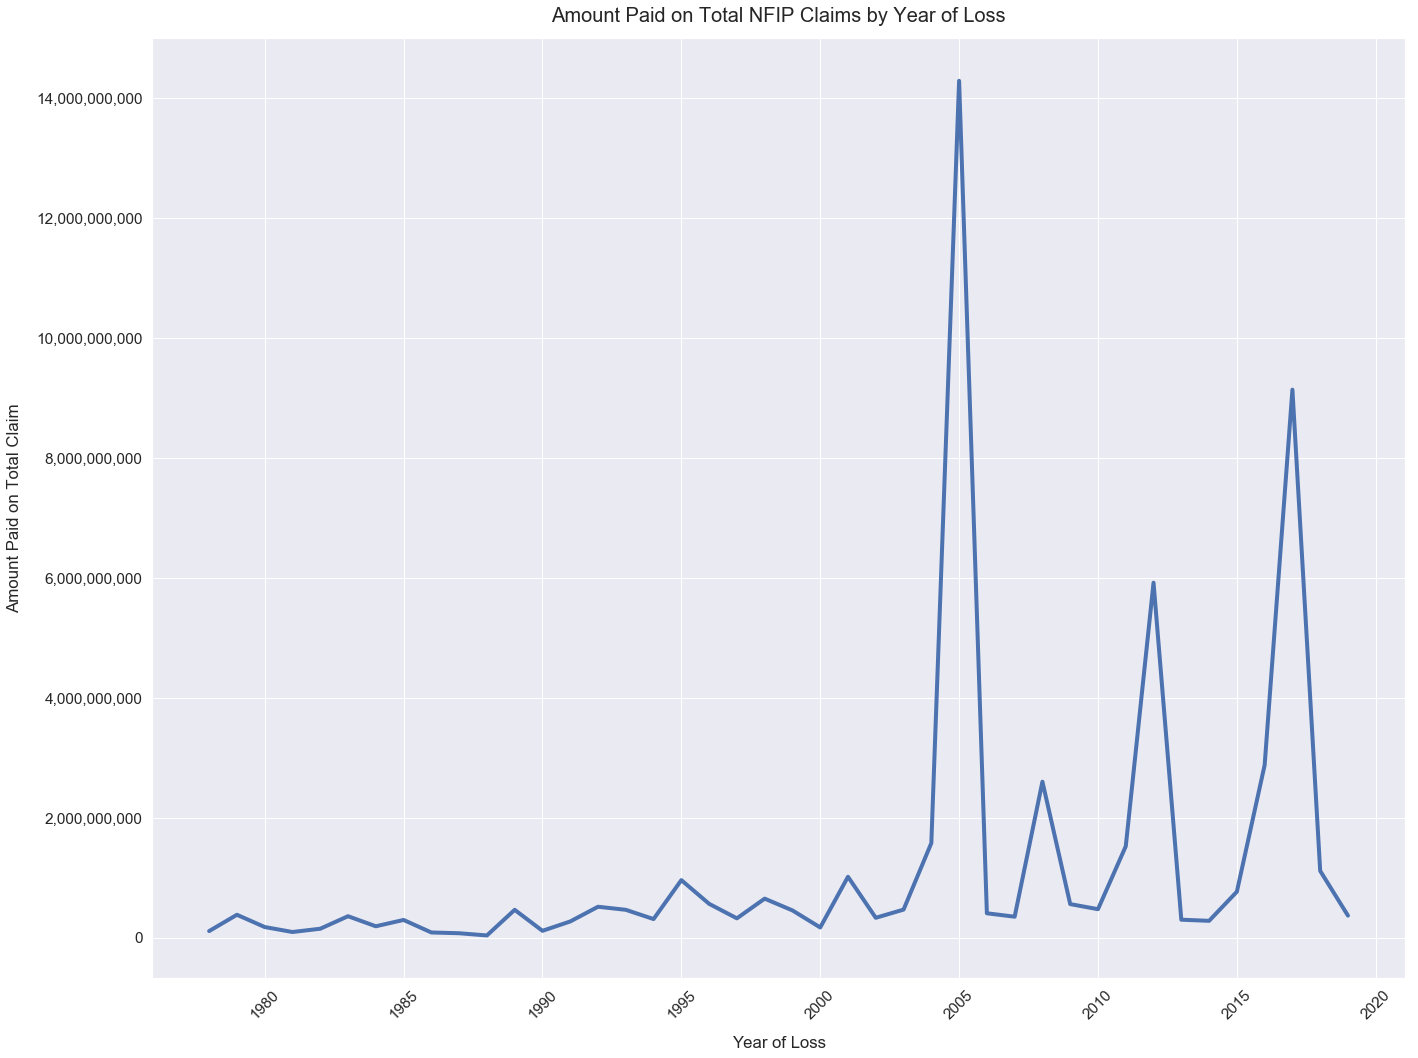

In [320]:
years = mdates.YearLocator(5)   # every 5 year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)


# plotting bar chart of number of claims by year
nfip_claims_year['amountpaidontotalclaim'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Amount Paid on Total NFIP Claims by Year of Loss", pad=16, fontsize=20)


plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-amount.png')

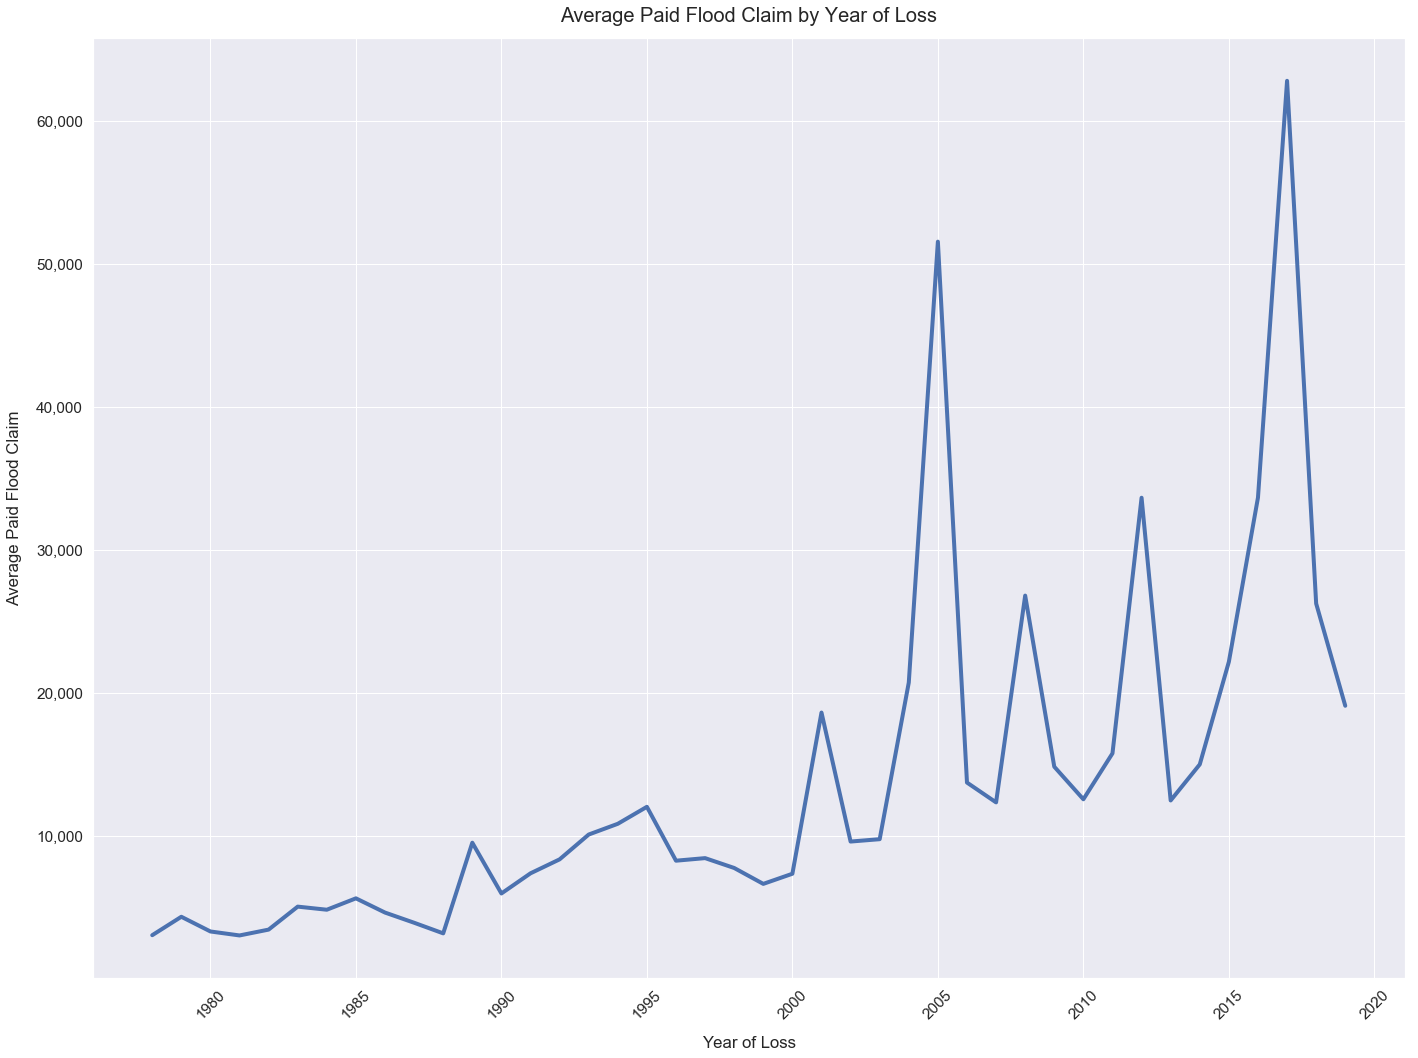

In [321]:
years = mdates.YearLocator(5)   # every 5 year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# plotting bar chart of number of claims by year
nfip_claims_year['average_paid_flood_claim'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Average Paid Flood Claim by Year of Loss", pad=16, fontsize=20)

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-average.png')

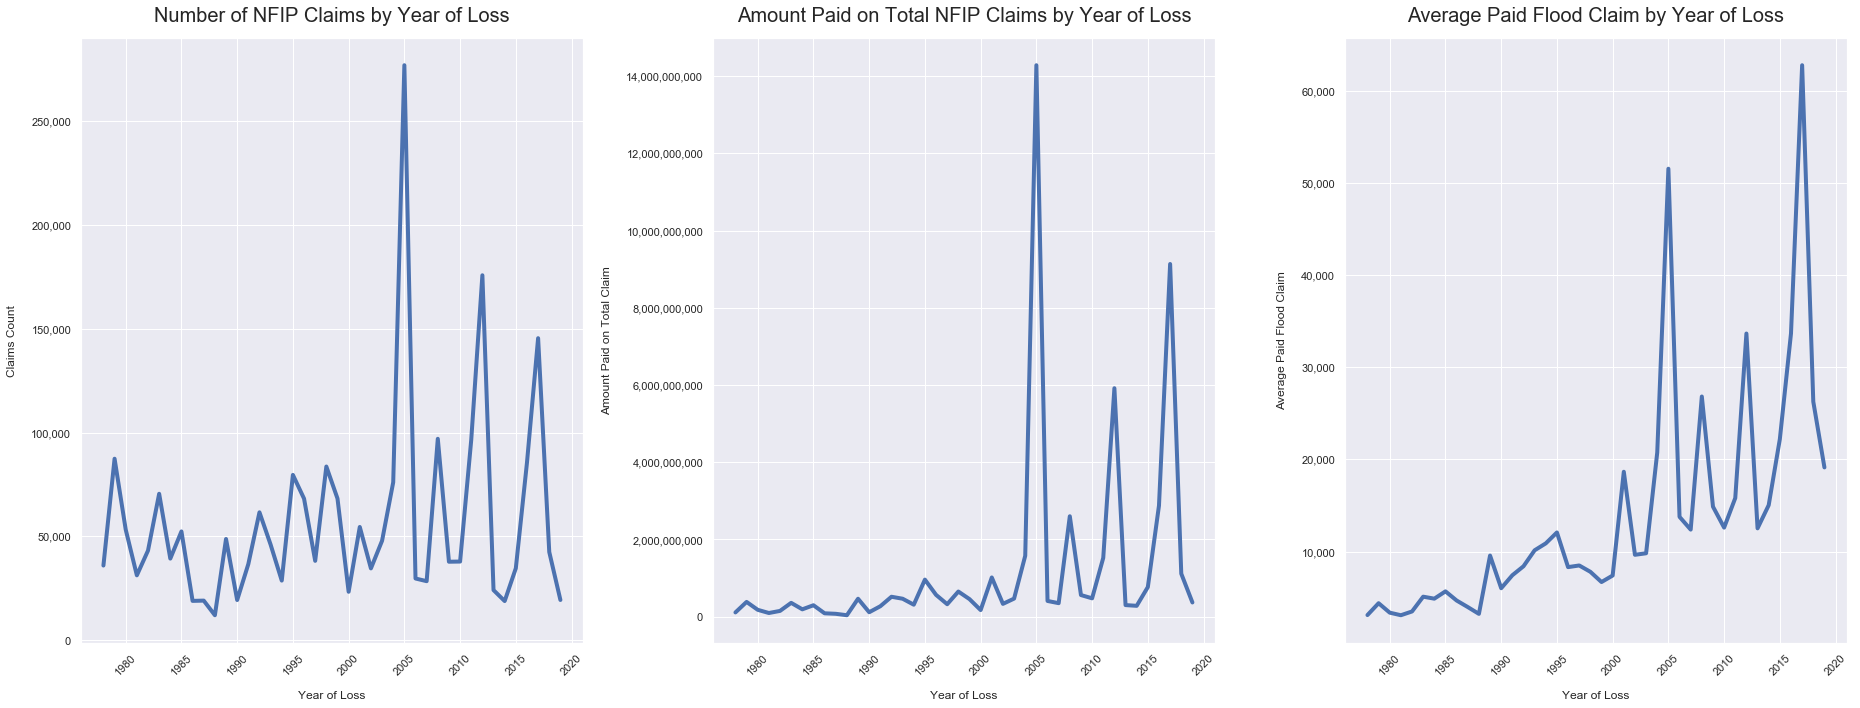

In [323]:
sns.set(font_scale=1)
fig = pl.figure(figsize=(26,10))


years = mdates.YearLocator(5)   # every 5 year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# adding first subplot
ax = fig.add_subplot(131)

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)


# plotting bar chart of number of claims by year
nfip_claims_year['claimscount'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Number of NFIP Claims by Year of Loss", pad=16, fontsize=20)

# adding second subplot
ax = fig.add_subplot(132)

years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)


# plotting bar chart of number of claims by year
nfip_claims_year['amountpaidontotalclaim'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Amount Paid on Total NFIP Claims by Year of Loss", pad=16, fontsize=20)


# adding third subplot
ax = fig.add_subplot(133)

years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# plotting bar chart of number of claims by year
nfip_claims_year['average_paid_flood_claim'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Average Paid Flood Claim by Year of Loss", pad=16, fontsize=20)

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-subplots.png')

In [324]:
nfip_claims_year.sort_values(by='claimscount', ascending=False).head(10)

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
yearofloss,,,,
2005-01-01,2005,277024,1.428216e+10,51555.69
2012-01-01,2012,175789,5.917678e+09,33663.53
2017-01-01,2017,145466,9.134276e+09,62793.20
2008-01-01,2008,96972,2.601392e+09,26826.22
2011-01-01,2011,96461,1.524503e+09,15804.34
1979-01-01,1979,87375,3.833123e+08,4386.98
2016-01-01,2016,85463,2.877588e+09,33670.57
1998-01-01,1998,83621,6.519203e+08,7796.13
1995-01-01,1995,79582,9.605043e+08,12069.37


In [325]:
nfip_claims_year.sort_values(by='amountpaidontotalclaim', ascending=False).head(10)

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
yearofloss,,,,
2005-01-01,2005,277024,1.428216e+10,51555.69
2017-01-01,2017,145466,9.134276e+09,62793.20
2012-01-01,2012,175789,5.917678e+09,33663.53
2016-01-01,2016,85463,2.877588e+09,33670.57
2008-01-01,2008,96972,2.601392e+09,26826.22
2004-01-01,2004,76033,1.577862e+09,20752.32
2011-01-01,2011,96461,1.524503e+09,15804.34
2018-01-01,2018,42429,1.114654e+09,26271.04
2001-01-01,2001,54492,1.016633e+09,18656.55


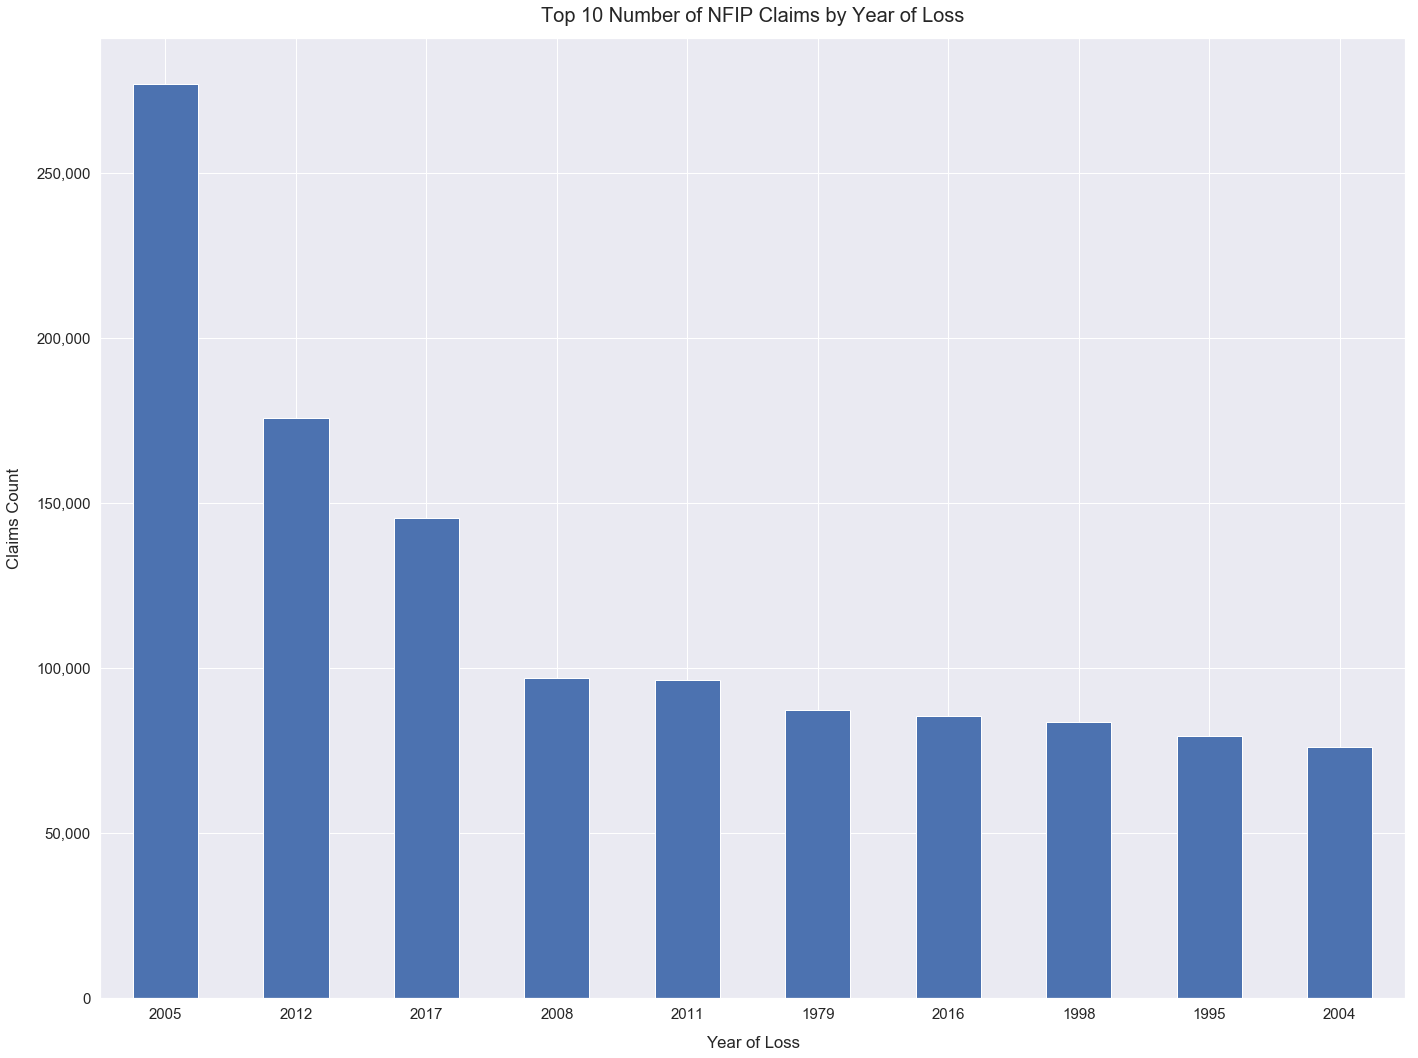

In [326]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_year.sort_values(by='claimscount', ascending=False).head(10).plot.bar(x='yearofloss', y='claimscount', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Top 10 Number of NFIP Claims by Year of Loss", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-count-top10.png')

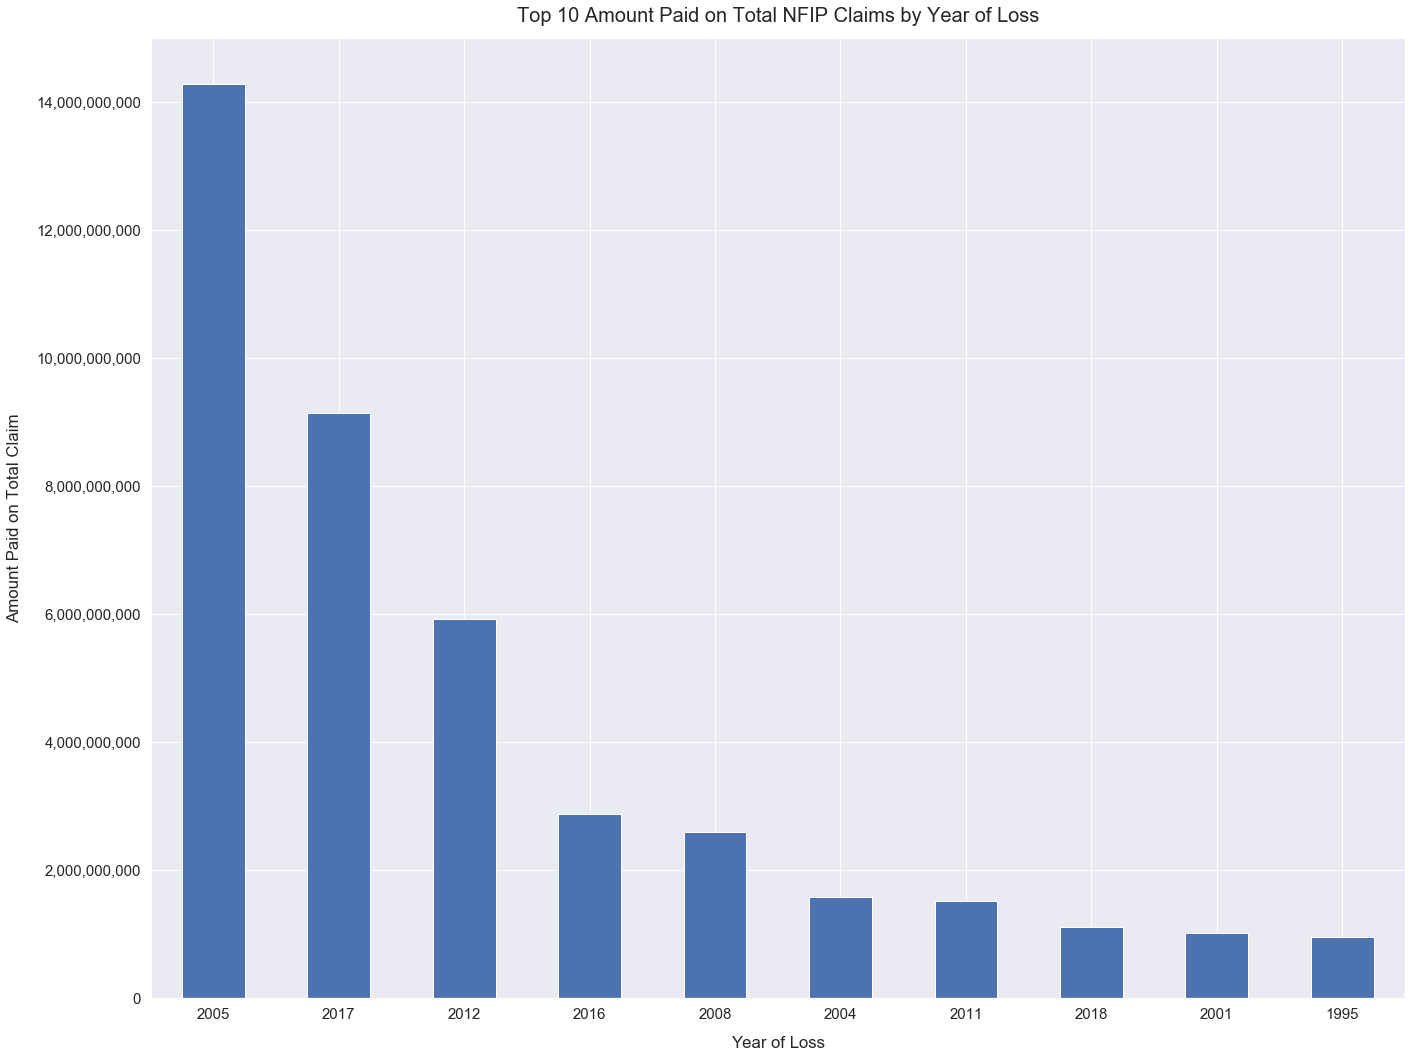

In [327]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_year.sort_values(by='amountpaidontotalclaim', ascending=False).head(10).plot.bar(x='yearofloss', y='amountpaidontotalclaim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Top 10 Amount Paid on Total NFIP Claims by Year of Loss", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-amount-top10.png')

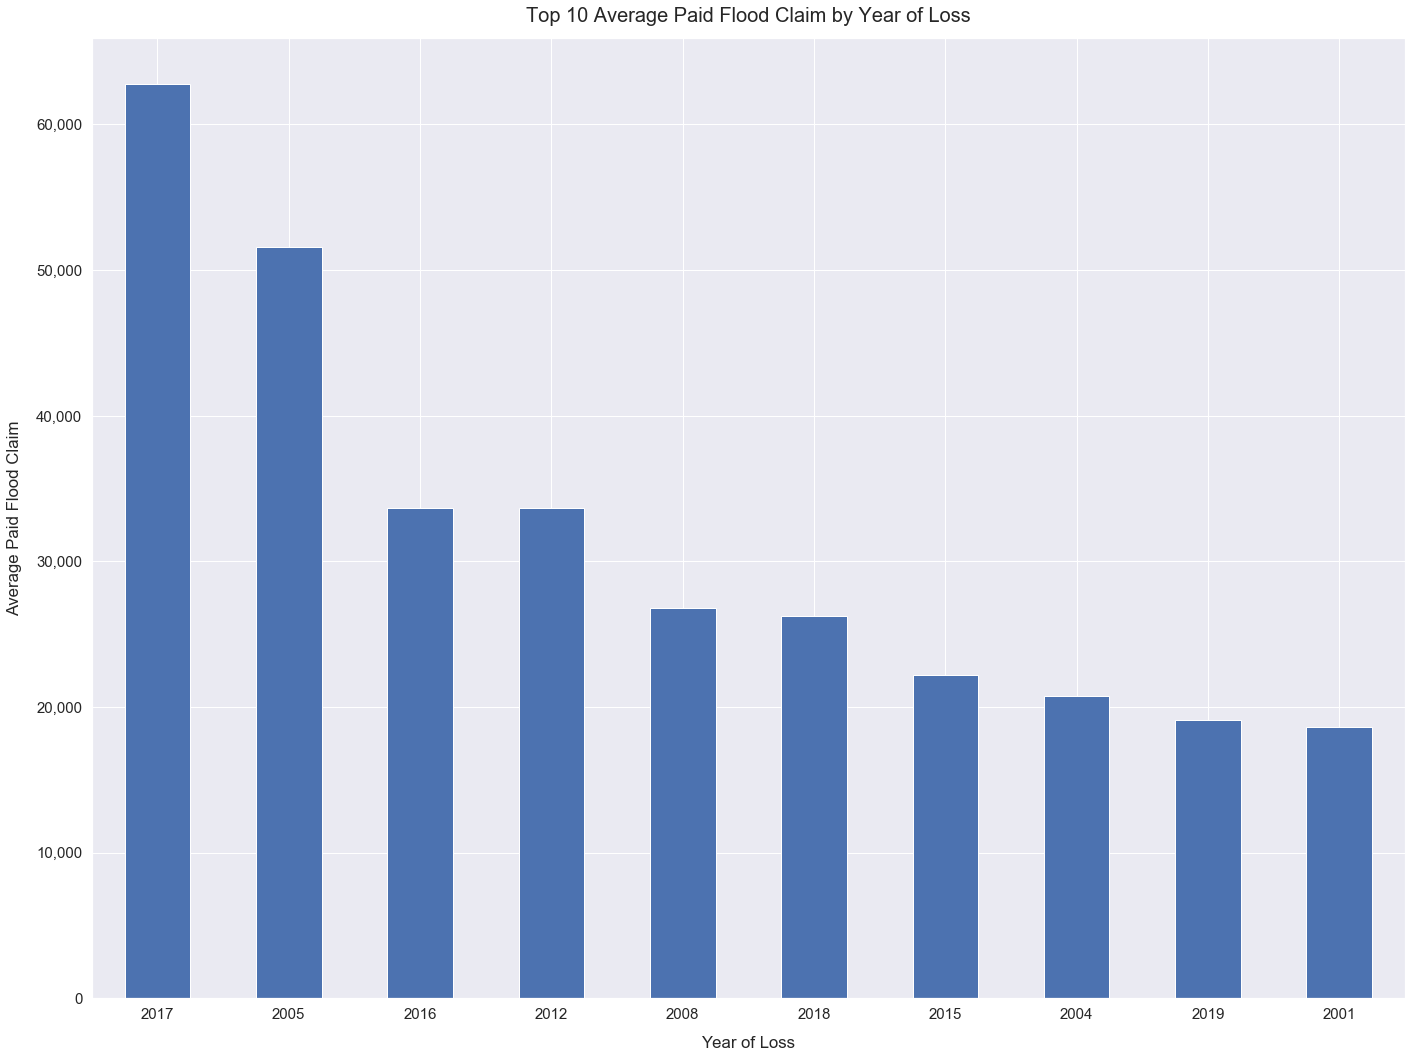

In [328]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_year.sort_values(by='average_paid_flood_claim', ascending=False).head(10).plot.bar(x='yearofloss', y='average_paid_flood_claim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Top 10 Average Paid Flood Claim by Year of Loss", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-average-top10.png')

## Analyzing NFIP Claims by State

### Group by Claims Count

In [329]:
# grouping dataframe by 'Year' and summing values of columns
nfip_claims_state_count = nfip_claims.groupby('state').count()

In [330]:
nfip_claims_state_count.head()

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,...,amountpaidonincreasedcostofcomplianceclaim,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,reportedzipcode,primaryresidence,amountpaidontotalclaim
state,,,,,,,,,,,,,,,,,,,,,
AK,9,665,161,665,663,657,665,659,665,665,...,260,642,658,18,665,665,665,663,375,372
AL,523,40579,14267,40579,40472,40222,40579,40564,40579,40579,...,20851,40087,40193,775,40579,40579,40579,40565,22425,29405
AR,971,9520,1003,9520,9487,9229,9520,9518,9520,9520,...,4670,9186,9204,1396,9520,9520,9520,9518,5909,4698
AS,3,10,0,10,10,10,10,9,10,10,...,2,5,10,3,10,10,10,10,8,6
AZ,164,4930,365,4930,4913,4603,4930,4914,4930,4930,...,1109,4614,4607,279,4930,4930,4930,4927,1737,2639


In [331]:
nfip_claims_state_count = nfip_claims_state_count[['asofdate']]

In [332]:
nfip_claims_state_count.head()

,asofdate
state,
AK,665
AL,40579
AR,9520
AS,10
AZ,4930


In [333]:
nfip_claims_state_count.rename(columns={"asofdate": "claimscount"}, inplace=True)
nfip_claims_state_count.head()

,claimscount
state,
AK,665
AL,40579
AR,9520
AS,10
AZ,4930


### Group by Claims Amount

In [334]:
# grouping dataframe by 'Year' and summing values of columns
nfip_claims_state_amount = nfip_claims.groupby('state').sum()

In [335]:
nfip_claims_state_amount.head()

,basefloodelevation,basementenclosurecrawlspacetype,policycount,countycode,crsdiscount,elevationdifference,censustract,latitude,longitude,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,occupancytype,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,amountpaidontotalclaim
state,,,,,,,,,,,,,,,,,,,,
AK,44248.1,422.0,665.0,1398866.0,5.45,452778.0,1.337755e+12,39898.8,-9.505690e+04,33220.2,43026.7,1222.0,893.0,8.939734e+06,8.384269e+05,69548.00,8.187620e+07,1.522120e+07,1330366,6.093653e+06
AL,494134.0,11307.0,71635.0,42697674.0,1111.50,23391851.0,4.092578e+13,1209919.8,-3.424157e+06,328303.9,666732.4,62002.0,57908.0,8.348512e+08,1.849333e+08,12251093.49,7.941176e+09,1.124686e+09,81080521,7.109164e+08
AR,323663.3,3060.0,9570.0,48354848.0,81.95,8213247.0,4.722956e+13,325871.0,-8.556071e+05,314951.6,496133.6,13564.0,14897.0,1.547125e+08,2.760943e+07,2028797.87,7.331774e+08,1.725668e+08,19055997,1.124066e+08
AS,0.0,0.0,10.0,540450.0,0.00,9990.0,5.404500e+11,-128.7,-1.536300e+03,0.0,0.0,5.0,20.0,2.467571e+04,1.141024e+04,0.00,2.099000e+05,2.790000e+04,20089,3.608595e+04
AZ,541648.9,1179.0,5022.0,19729156.0,178.50,4508248.0,1.908340e+13,159476.6,-5.329239e+05,453078.2,533497.6,6817.0,7488.0,4.375293e+07,8.056271e+06,50000.00,4.717091e+08,9.800870e+07,9831100,3.314879e+07


In [336]:
nfip_claims_state_amount = nfip_claims_state_amount[['amountpaidontotalclaim']]

In [337]:
nfip_claims_state_amount.head()

,amountpaidontotalclaim
state,
AK,6.093653e+06
AL,7.109164e+08
AR,1.124066e+08
AS,3.608595e+04
AZ,3.314879e+07


### Merging both dataframes (i.e. claims count and amount)

In [338]:
nfip_claims_state_count.reset_index(inplace=True)
nfip_claims_state_amount.reset_index(inplace=True)

In [339]:
# merging both data frames (count and claim amount) by borough name
nfip_claims_state = nfip_claims_state_count.merge(nfip_claims_state_amount, left_on="state", 
              right_on="state")

In [340]:
nfip_claims_state.head()

,state,claimscount,amountpaidontotalclaim
0,AK,665,6.093653e+06
1,AL,40579,7.109164e+08
2,AR,9520,1.124066e+08
3,AS,10,3.608595e+04
4,AZ,4930,3.314879e+07


In [341]:
nfip_claims_state['average_paid_flood_claim'] = nfip_claims_state['amountpaidontotalclaim'] / nfip_claims_state['claimscount']

In [342]:
nfip_claims_state.head()

,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,AK,665,6.093653e+06,9163.387504
1,AL,40579,7.109164e+08,17519.318986
2,AR,9520,1.124066e+08,11807.413774
3,AS,10,3.608595e+04,3608.595000
4,AZ,4930,3.314879e+07,6723.893503


In [343]:
nfip_claims_state.sort_values(by='claimscount', ascending=False).head(10)

,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim
20,LA,458689,1.528976e+10,33333.602422
46,TX,371330,1.388437e+10,37390.928959
10,FL,295397,4.137478e+09,14006.498733
33,NJ,191581,3.592012e+09,18749.311213
36,NY,167128,3.309984e+09,19805.080931
29,NC,101119,1.277678e+09,12635.393743
40,PA,73110,8.167062e+08,11170.922642
27,MS,62698,2.460959e+09,39250.989020
16,IL,51807,3.226279e+08,6227.495665
5,CA,50205,3.617841e+08,7206.136775


In [344]:
nfip_claims_state.sort_values(by='amountpaidontotalclaim', ascending=False).head(10)

,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim
20,LA,458689,1.528976e+10,33333.602422
46,TX,371330,1.388437e+10,37390.928959
10,FL,295397,4.137478e+09,14006.498733
33,NJ,191581,3.592012e+09,18749.311213
36,NY,167128,3.309984e+09,19805.080931
27,MS,62698,2.460959e+09,39250.989020
29,NC,101119,1.277678e+09,12635.393743
40,PA,73110,8.167062e+08,11170.922642
1,AL,40579,7.109164e+08,17519.318986
43,SC,45720,6.147841e+08,13446.721741


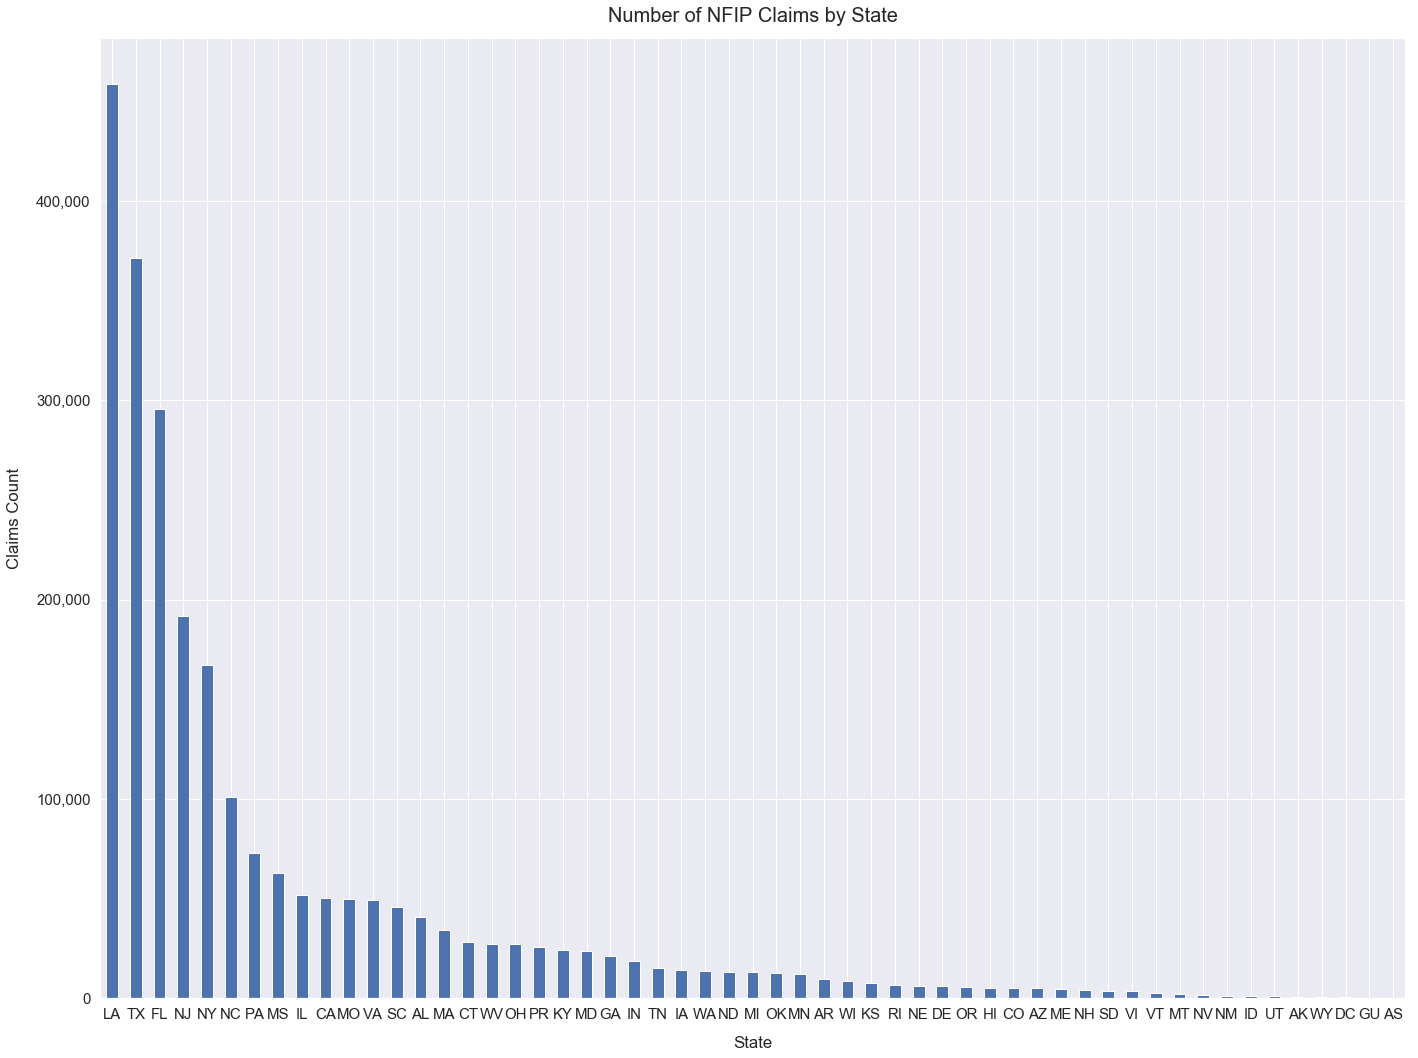

In [345]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='claimscount', ascending=False).plot.bar(x='state', y='claimscount', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Number of NFIP Claims by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-count.png')

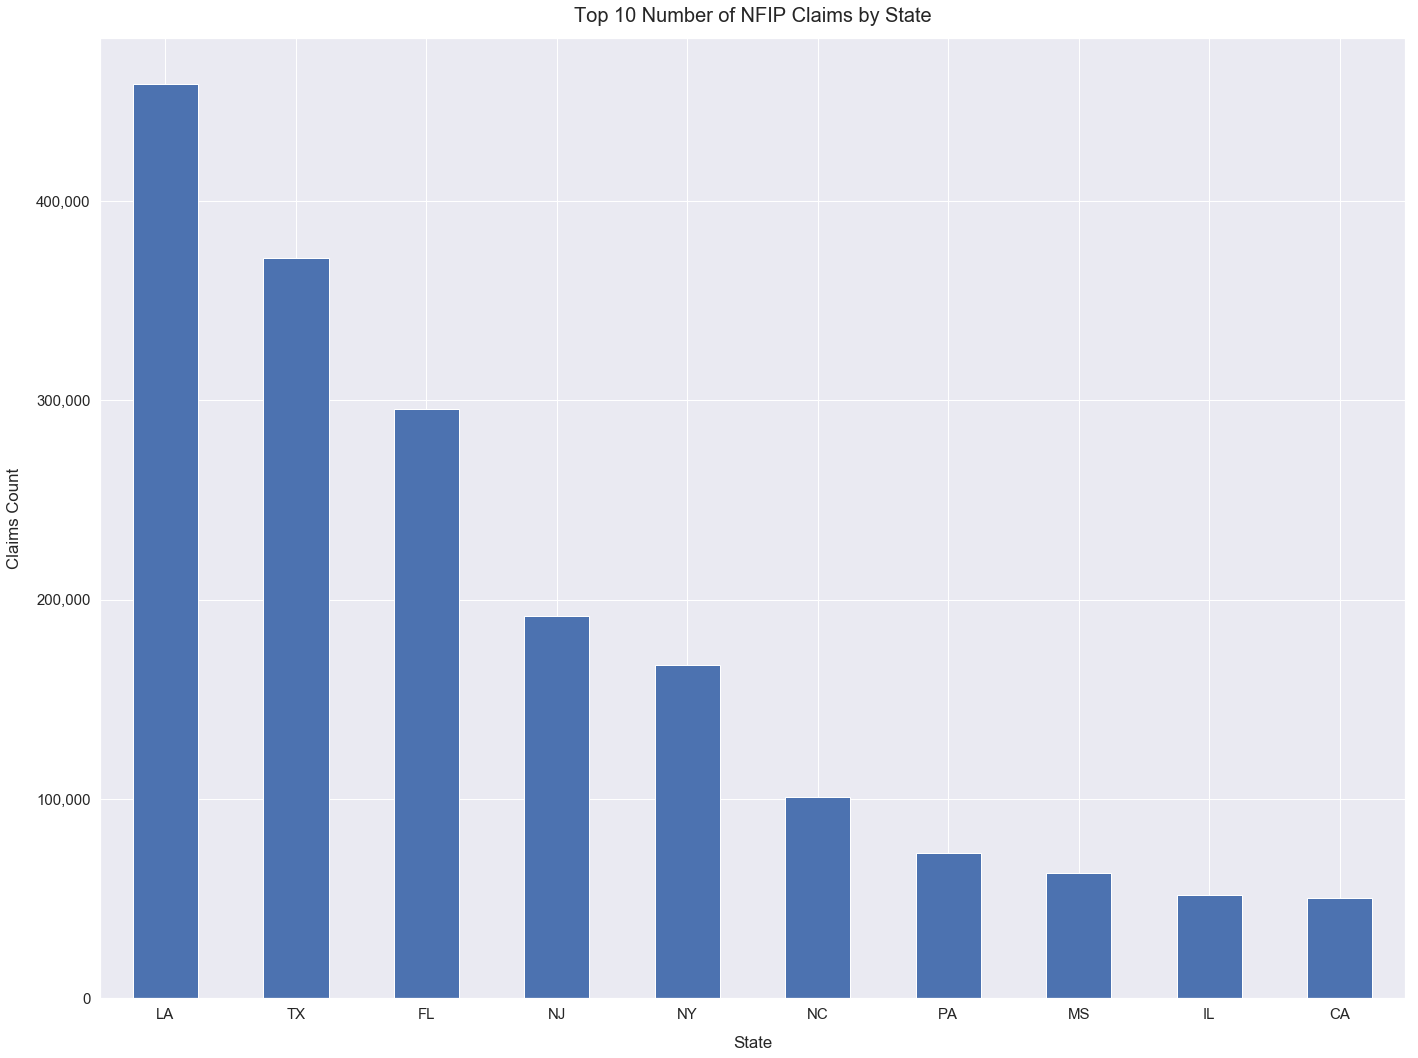

In [346]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='claimscount', ascending=False).head(10).plot.bar(x='state', y='claimscount', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Top 10 Number of NFIP Claims by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-count-top10.png')

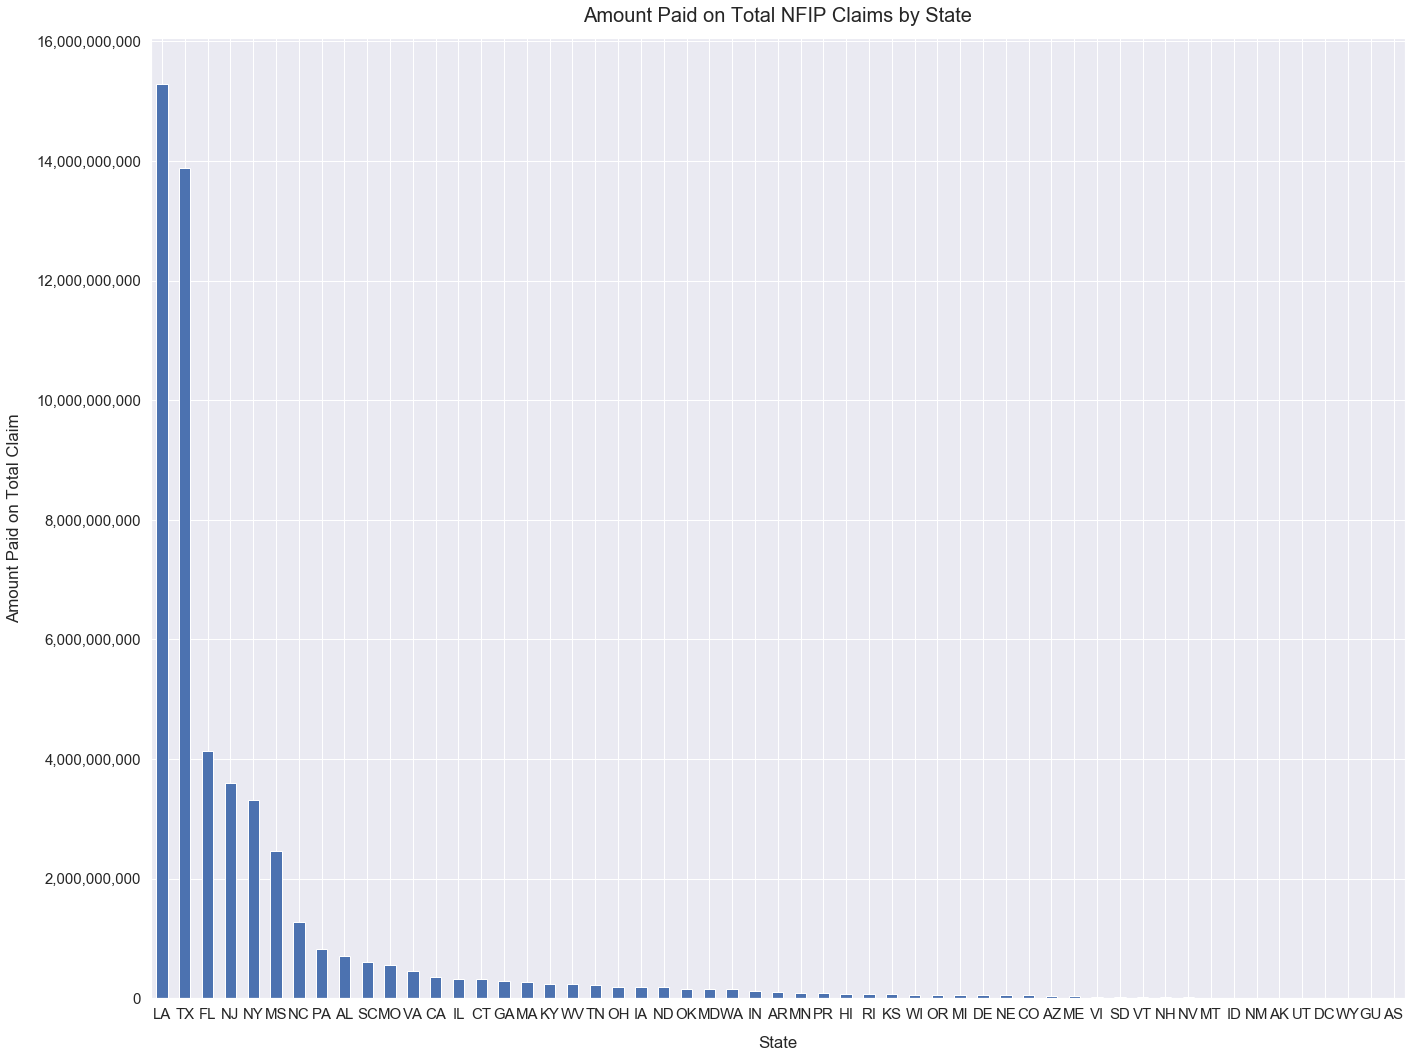

In [347]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='amountpaidontotalclaim', ascending=False).plot.bar(x='state', y='amountpaidontotalclaim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Amount Paid on Total NFIP Claims by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-amount.png')

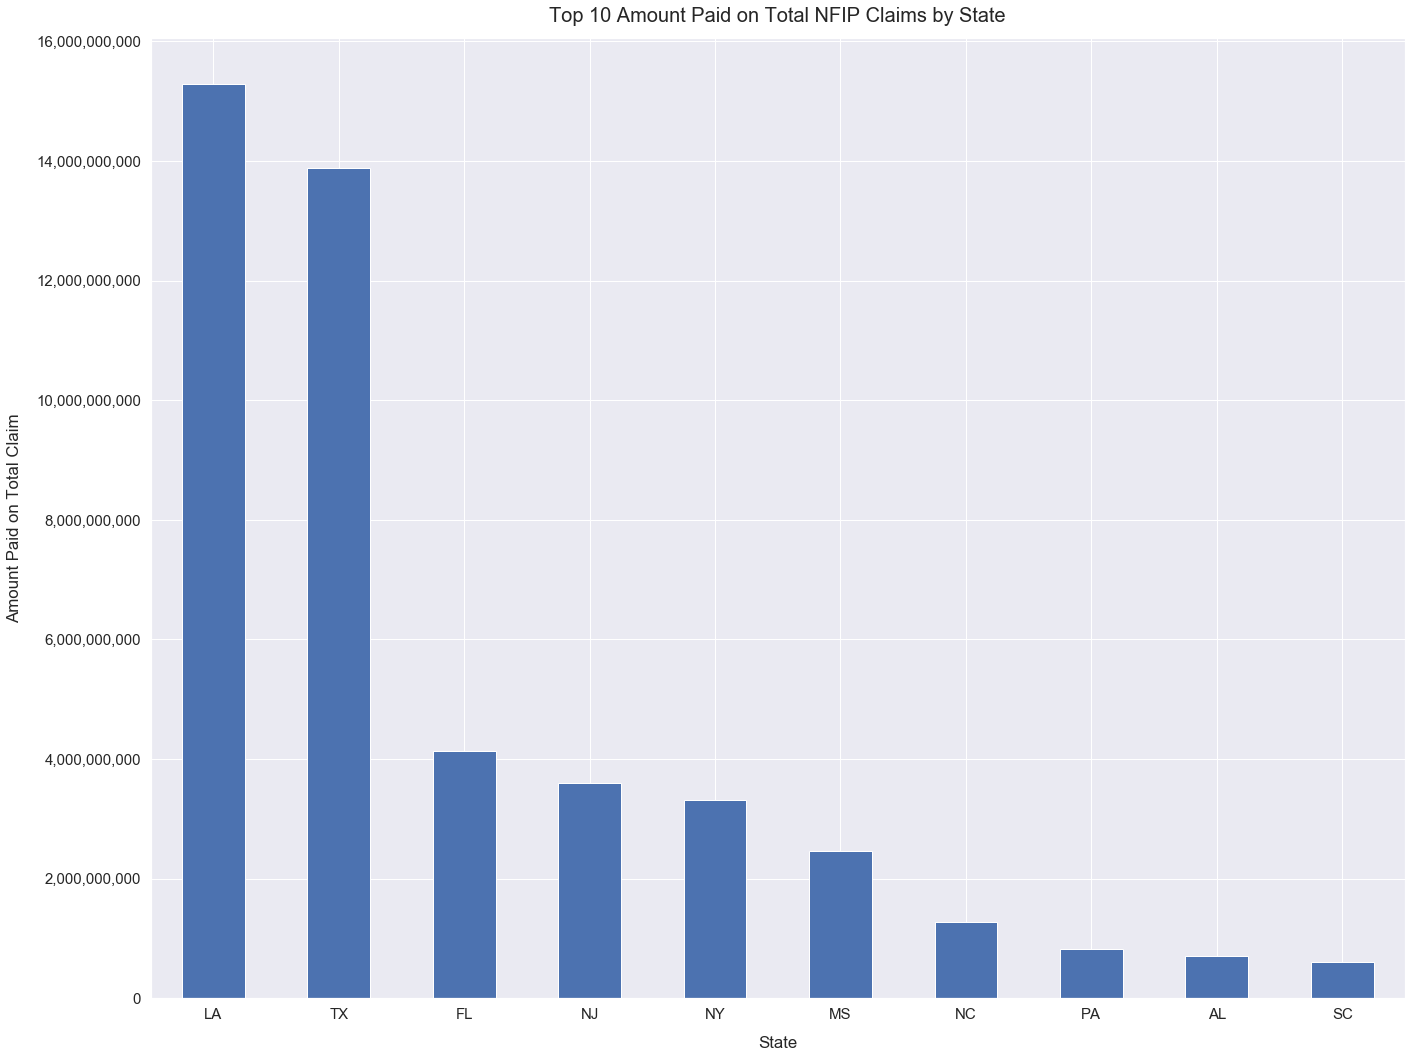

In [348]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='amountpaidontotalclaim', ascending=False).head(10).plot.bar(x='state', y='amountpaidontotalclaim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Top 10 Amount Paid on Total NFIP Claims by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-amount-top10.png')

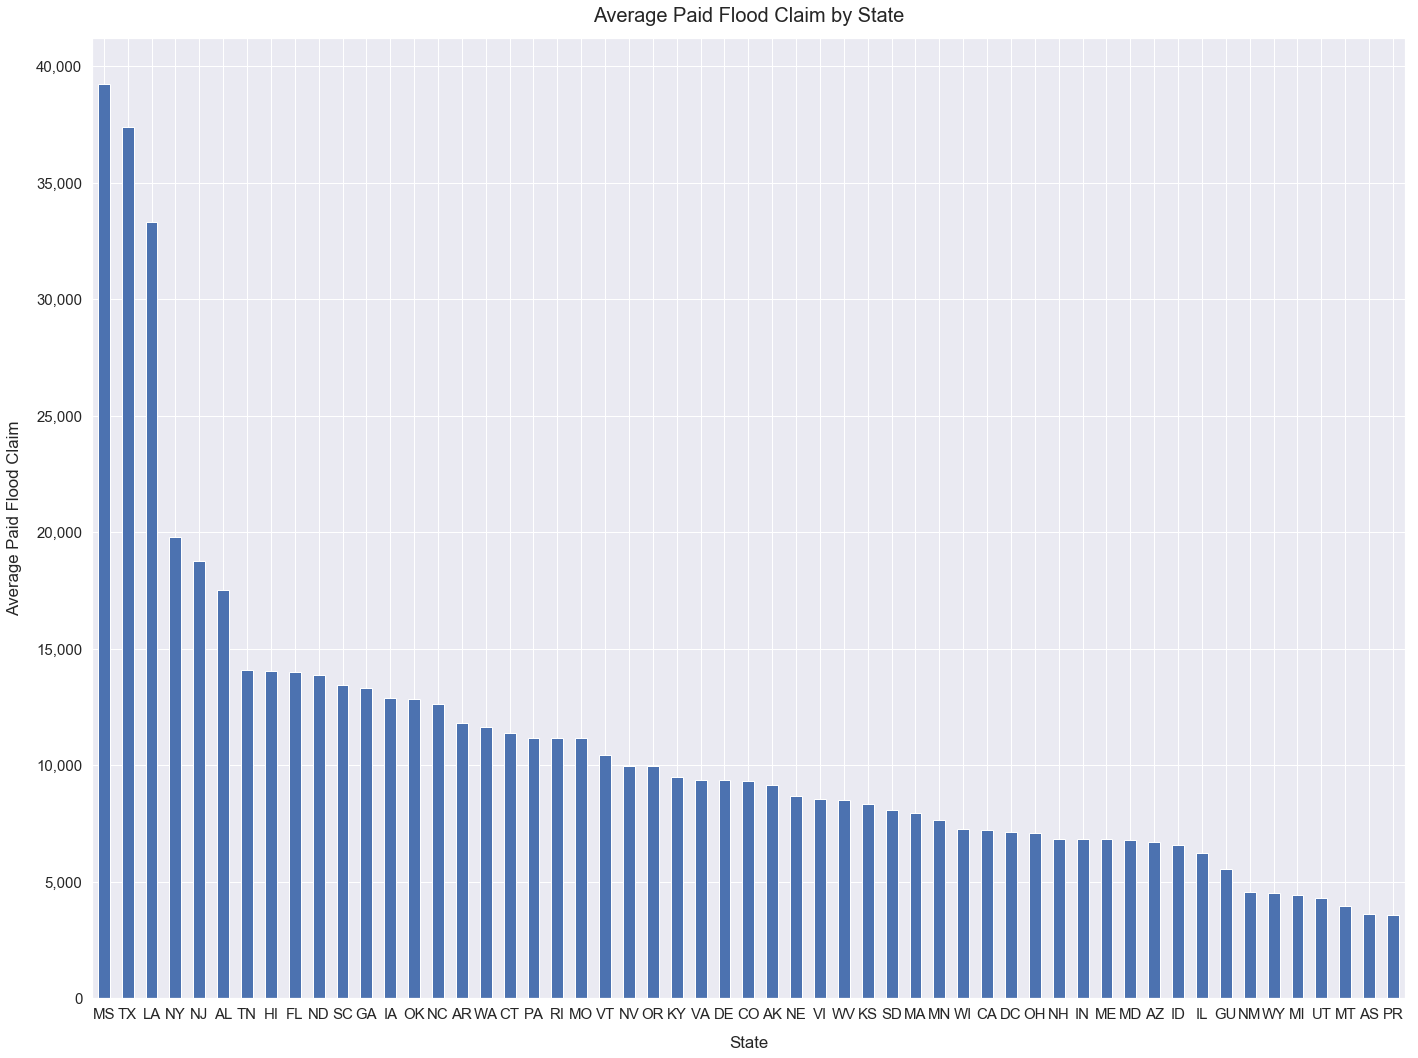

In [349]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='average_paid_flood_claim', ascending=False).plot.bar(x='state', y='average_paid_flood_claim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Average Paid Flood Claim by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-amount-average.png')

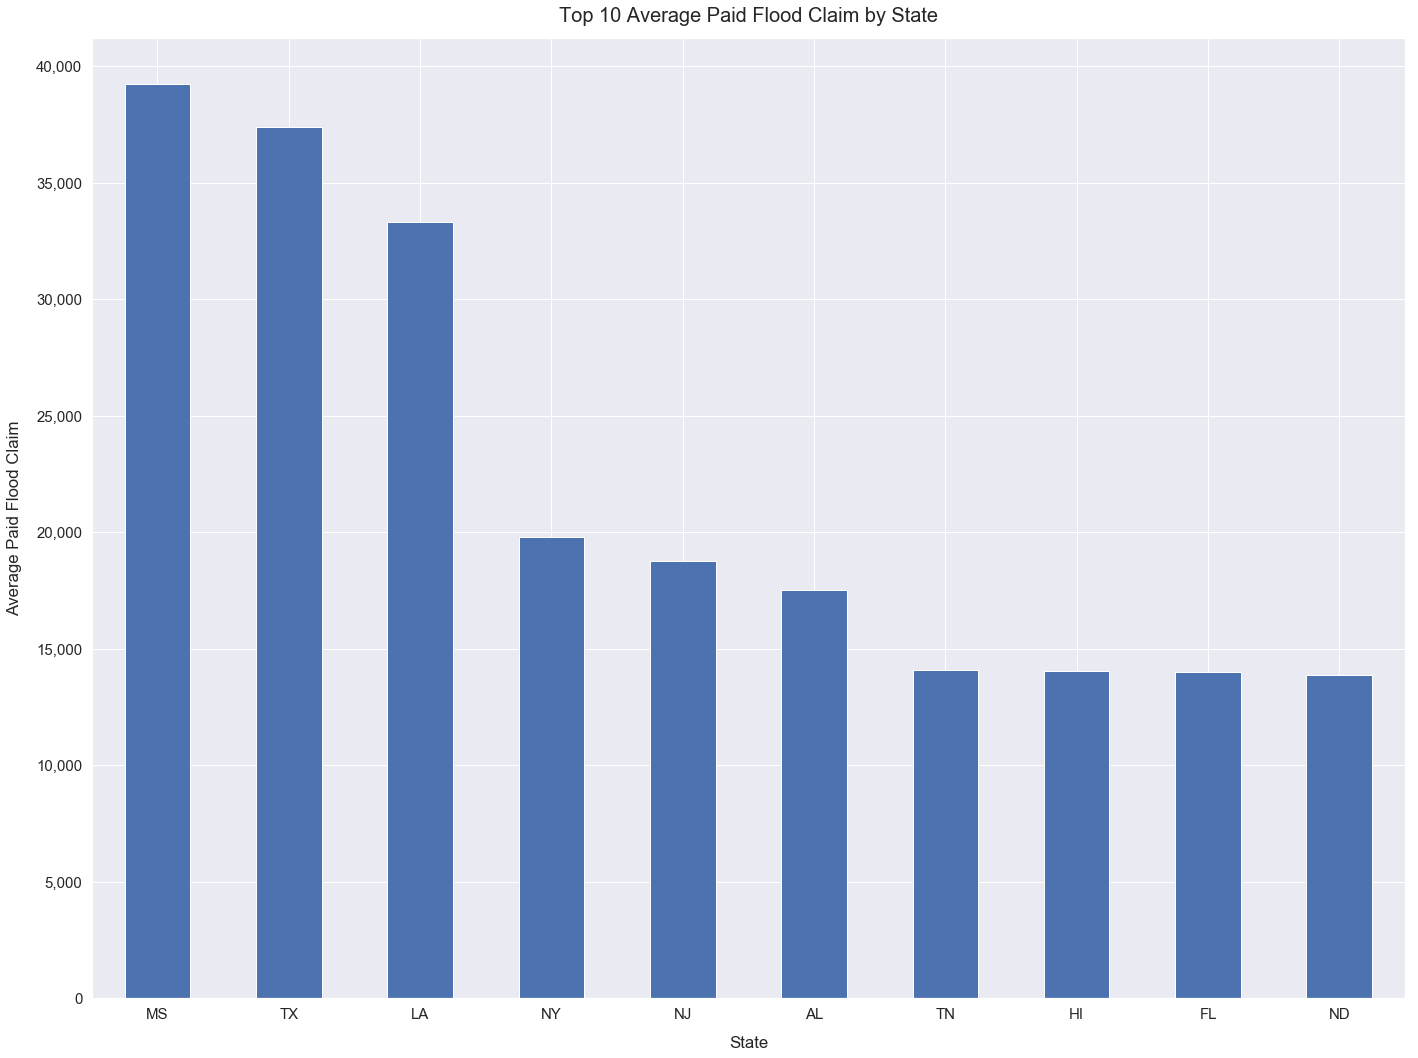

In [350]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='average_paid_flood_claim', ascending=False).head(10).plot.bar(x='state', y='average_paid_flood_claim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Top 10 Average Paid Flood Claim by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-amount-average-top10.png')

# Mapping

In [351]:
# changing directories to Downloads folder
%cd ~/Downloads/

/Users/geribauer/Downloads


In [35]:
# dowloading the data with urllib.request.urlretrieve()
url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'

# retrieving the file and naming it as 'nfip_claims.gz'
urllib.request.urlretrieve(url, "cb_2018_us_state_500k.gz")

('cb_2018_us_state_500k.gz', <http.client.HTTPMessage at 0x1a2491f080>)

In [36]:
# unzipping the file
!unzip -d ~/Downloads/ cb_2018_us_state_500k.gz

Archive:  cb_2018_us_state_500k.gz
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.shp.ea.iso.xml  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.shp.iso.xml  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.shp  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.shx  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.dbf  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.prj  
 extracting: /Users/geribauer/Downloads/cb_2018_us_state_500k.cpg  


In [352]:
states_shape = gpd.GeoDataFrame.from_file('cb_2018_us_state_500k.shp')


In [353]:
states_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"(POLYGON ((-88.502966 30.215235, -88.491759 30..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"(POLYGON ((-75.72680699999999 35.935844, -75.7..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.002565 36.526588, -103.002188 3..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"(POLYGON ((-75.742406 37.80835, -75.741512 37...."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6431981036679 38.1690897960737, ..."


In [354]:
states_shape.shape

(56, 10)

In [355]:
states_shape.STATEFP = states_shape.STATEFP.astype('int64')

In [356]:
states_shape.sort_values(by='STATEFP', ascending=False).head(10)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
38,78,01802710,0400000US78,78,VI,United States Virgin Islands,00,348021896,1550236201,"(POLYGON ((-64.62798599999999 17.789326, -64.6..."
13,72,01779808,0400000US72,72,PR,Puerto Rico,00,8868896030,4922382562,"(POLYGON ((-65.23805299999999 18.321667, -65.2..."
45,69,01779809,0400000US69,69,MP,Commonwealth of the Northern Mariana Islands,00,472292529,4644252461,"(POLYGON ((146.051034 16.006741, 146.051668 16..."
44,66,01802705,0400000US66,66,GU,Guam,00,543555840,934337453,"(POLYGON ((144.645379 13.236271, 144.647162 13..."
37,60,01802701,0400000US60,60,AS,American Samoa,00,197759063,1307243754,"(POLYGON ((-168.145824 -14.547906, -168.145605..."
24,56,01779807,0400000US56,56,WY,Wyoming,00,251458544898,1867670745,"POLYGON ((-111.054556 45.000955, -111.04506604..."
49,55,01779806,0400000US55,55,WI,Wisconsin,00,140290039723,29344951758,"(POLYGON ((-86.95616699999999 45.355489, -86.9..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6431981036679 38.1690897960737, ..."
11,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"(POLYGON ((-122.570392 48.537853, -122.568628 ..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"(POLYGON ((-75.742406 37.80835, -75.741512 37...."


In [357]:
states_shape.STATEFP.unique()

array([28, 37, 40, 51, 54, 22, 26, 25, 16, 12, 31, 53, 35, 72, 46, 48,  6,
        1, 13, 42, 29,  8, 49, 47, 56, 36, 20,  2, 32, 17, 50, 30, 19, 45,
       33,  4, 11, 60, 78, 34, 24, 23, 15, 10, 66, 69, 44, 21, 39, 55, 41,
       38,  5, 18, 27,  9])

In [358]:
states_shape  = states_shape.loc[states_shape.STATEFP < 57]

In [359]:
states_shape.sort_values(by='STATEFP', ascending=False).head(10)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
24,56,01779807,0400000US56,56,WY,Wyoming,00,251458544898,1867670745,"POLYGON ((-111.054556 45.000955, -111.04506604..."
49,55,01779806,0400000US55,55,WI,Wisconsin,00,140290039723,29344951758,"(POLYGON ((-86.95616699999999 45.355489, -86.9..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6431981036679 38.1690897960737, ..."
11,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"(POLYGON ((-122.570392 48.537853, -122.568628 ..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"(POLYGON ((-75.742406 37.80835, -75.741512 37...."
30,50,01779802,0400000US50,50,VT,Vermont,00,23874175944,1030416650,"POLYGON ((-73.43773999999999 44.045006, -73.43..."
22,49,01455989,0400000US49,49,UT,Utah,00,212886221680,6998824394,"POLYGON ((-114.052962 37.592783, -114.052472 3..."
15,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"(POLYGON ((-94.718296 29.728855, -94.717207 29..."
23,47,01325873,0400000US47,47,TN,Tennessee,00,106802728188,2350123465,"POLYGON ((-90.31029799999999 35.004295, -90.30..."
14,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.057879 44.997605, -104.050783 4..."


In [360]:
states_shape.NAME.unique()

array(['Mississippi', 'North Carolina', 'Oklahoma', 'Virginia',
       'West Virginia', 'Louisiana', 'Michigan', 'Massachusetts', 'Idaho',
       'Florida', 'Nebraska', 'Washington', 'New Mexico', 'South Dakota',
       'Texas', 'California', 'Alabama', 'Georgia', 'Pennsylvania',
       'Missouri', 'Colorado', 'Utah', 'Tennessee', 'Wyoming', 'New York',
       'Kansas', 'Alaska', 'Nevada', 'Illinois', 'Vermont', 'Montana',
       'Iowa', 'South Carolina', 'New Hampshire', 'Arizona',
       'District of Columbia', 'New Jersey', 'Maryland', 'Maine',
       'Hawaii', 'Delaware', 'Rhode Island', 'Kentucky', 'Ohio',
       'Wisconsin', 'Oregon', 'North Dakota', 'Arkansas', 'Indiana',
       'Minnesota', 'Connecticut'], dtype=object)

In [361]:
states_shape = states_shape[['STUSPS', 'geometry']]

In [362]:
states_shape.head()

,STUSPS,geometry
0,MS,"(POLYGON ((-88.502966 30.215235, -88.491759 30..."
1,NC,"(POLYGON ((-75.72680699999999 35.935844, -75.7..."
2,OK,"POLYGON ((-103.002565 36.526588, -103.002188 3..."
3,VA,"(POLYGON ((-75.742406 37.80835, -75.741512 37...."
4,WV,"POLYGON ((-82.6431981036679 38.1690897960737, ..."


(-197.09527795, 197.72483895, 16.28762095, 73.98790205000002)

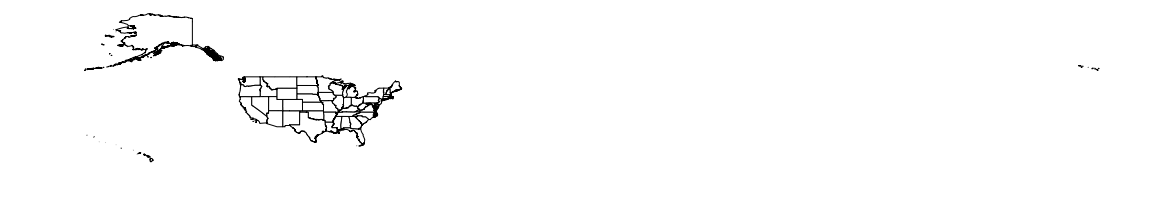

In [363]:
fig, ax = plt.subplots(figsize=(20,15))

states_shape.plot(ax=ax, color='w', edgecolor='black')

# Insert comment here
plt.axis('off')

In [364]:
delete_states = ['AK', 'HI']

In [365]:
states_shape  = states_shape.loc[~states_shape['STUSPS'].isin(delete_states)]

(-127.65372665, -64.05923634999999, 23.280032900000002, 50.6274211)

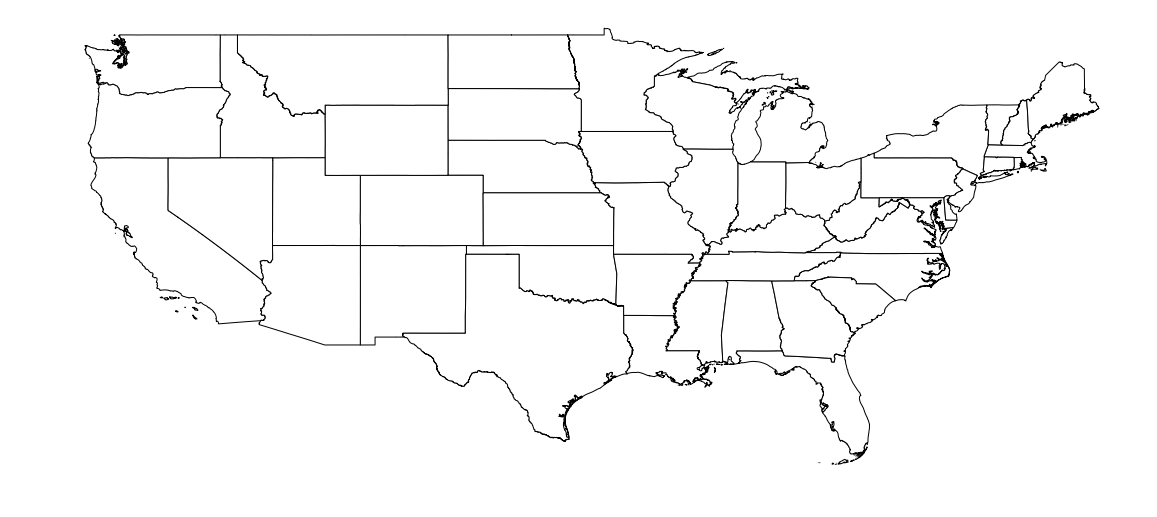

In [366]:
fig, ax = plt.subplots(figsize=(20,15))

states_shape.plot(ax=ax, color='w', edgecolor='black')

# Insert comment here
plt.axis('off')

In [367]:
states_shape.crs

{'init': 'epsg:4269'}

In [368]:
states_shape = states_shape.to_crs(epsg=2163)

(-2259318.989842429,
 2743787.7776512564,
 -2259441.9737315555,
 874818.5571526419)

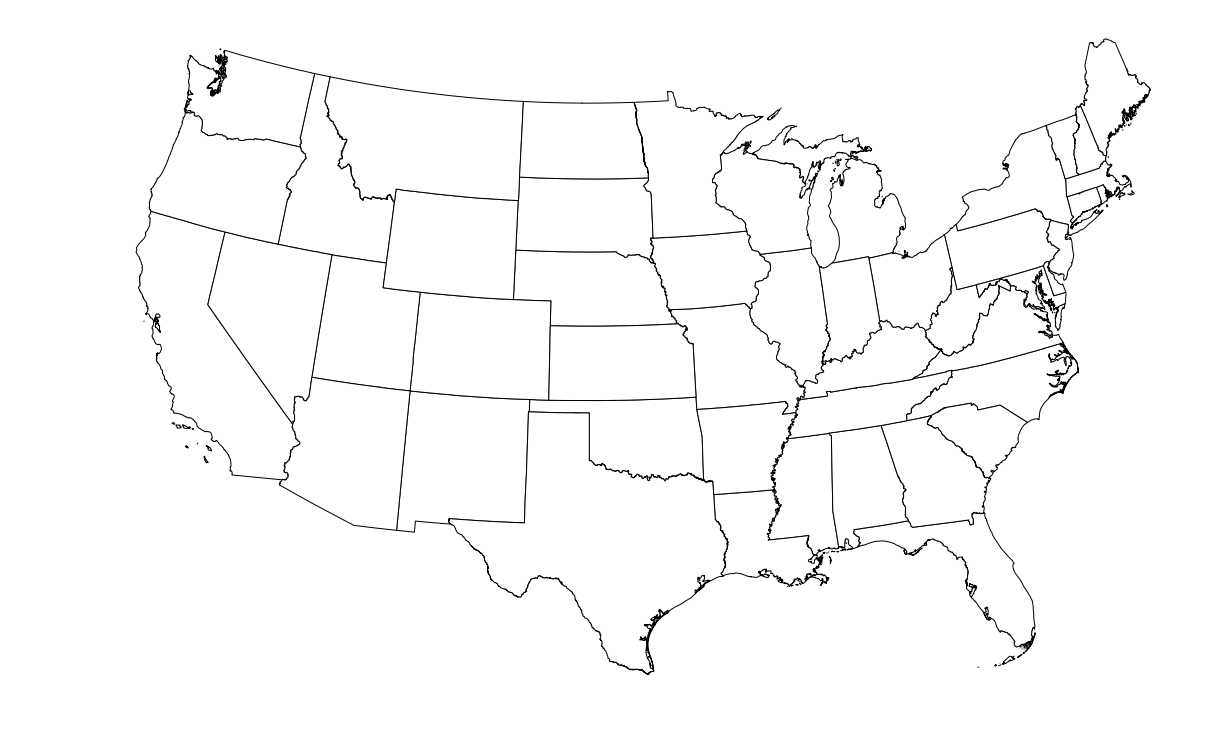

In [369]:
fig, ax = plt.subplots(figsize=(20,15))

states_shape.plot(ax=ax, color='w', edgecolor='black')

# Insert comment here
plt.axis('off')

In [370]:
%cd ~/fema-nfip-claims/nfip-claims-national

/Users/geribauer/fema-nfip-claims/nfip-claims-national


In [371]:
nfip_claims_state_map = states_shape.merge(nfip_claims_state, left_on="STUSPS", 
              right_on="state")

In [372]:
nfip_claims_state_map.head()

,STUSPS,geometry,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,MS,(POLYGON ((1109990.968252456 -1565553.47260314...,MS,62698,2.460959e+09,39250.989020
1,NC,(POLYGON ((2154835.72962173 -692236.3180788131...,NC,101119,1.277678e+09,12635.393743
2,OK,POLYGON ((-268956.1527428209 -936541.911155743...,OK,12675,1.626285e+08,12830.652256
3,VA,(POLYGON ((2098181.788299462 -490386.322096654...,VA,49116,4.609622e+08,9385.172944
4,WV,POLYGON ((1506493.502378316 -601384.4489765986...,WV,27244,2.320527e+08,8517.572584


In [373]:
nfip_claims_state_map.shape

(49, 6)

In [374]:
nfip_claims_state_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 6 columns):
STUSPS                      49 non-null object
geometry                    49 non-null object
state                       49 non-null object
claimscount                 49 non-null int64
amountpaidontotalclaim      49 non-null float64
average_paid_flood_claim    49 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.7+ KB


In [375]:
nfip_claims_state_map['amountpaidontotalclaim-bn']  = nfip_claims_state_map.amountpaidontotalclaim / 1000000000

In [376]:
nfip_claims_state_map.head()

,STUSPS,geometry,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim,amountpaidontotalclaim-bn
0,MS,(POLYGON ((1109990.968252456 -1565553.47260314...,MS,62698,2.460959e+09,39250.989020,2.460959
1,NC,(POLYGON ((2154835.72962173 -692236.3180788131...,NC,101119,1.277678e+09,12635.393743,1.277678
2,OK,POLYGON ((-268956.1527428209 -936541.911155743...,OK,12675,1.626285e+08,12830.652256,0.162629
3,VA,(POLYGON ((2098181.788299462 -490386.322096654...,VA,49116,4.609622e+08,9385.172944,0.460962
4,WV,POLYGON ((1506493.502378316 -601384.4489765986...,WV,27244,2.320527e+08,8517.572584,0.232053


In [377]:
nfip_claims_state_map = nfip_claims_state_map.round({'average_paid_flood_claim': 2, 'amountpaidontotalclaim-bn': 2})

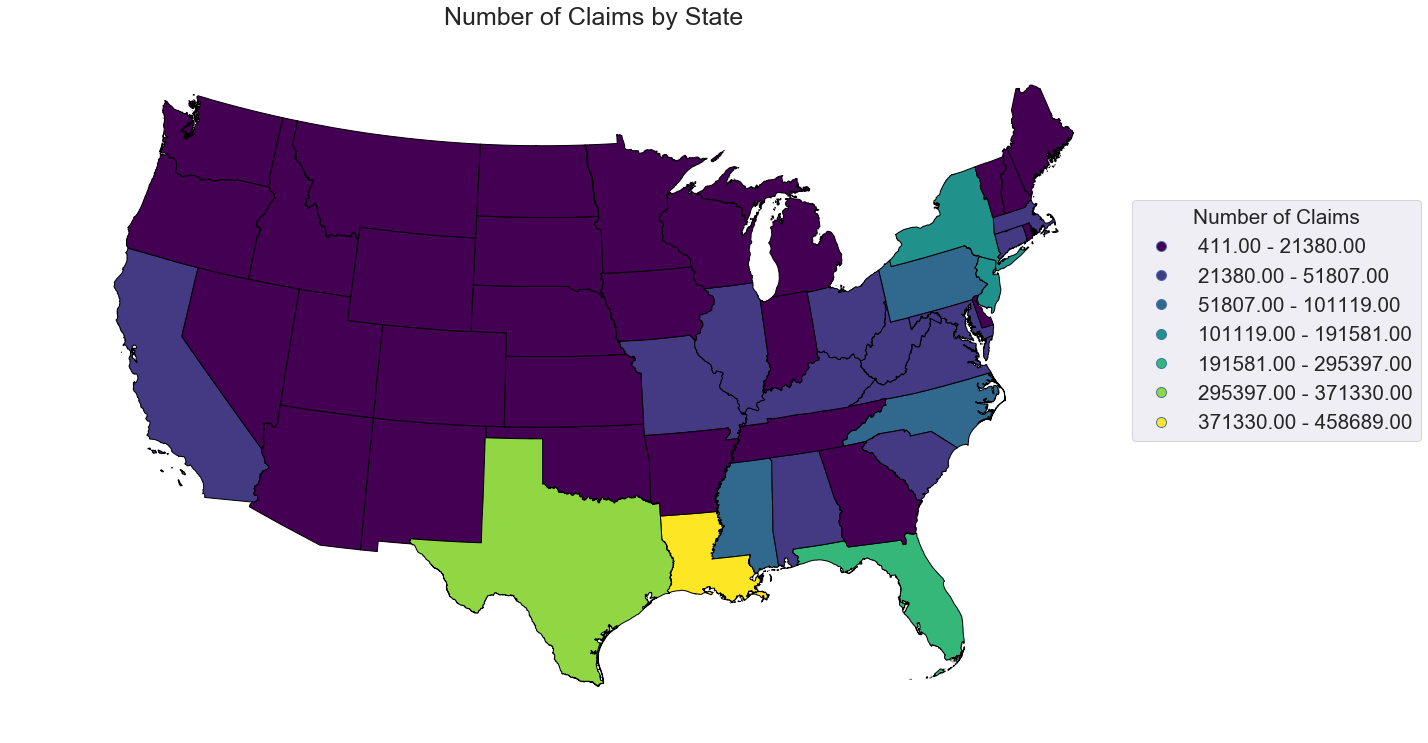

In [383]:
# defining our plot
plt.subplots(figsize=(20,15))
ax = plt.subplot()

nfip_claims_state_map.plot(column="claimscount", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   legend_kwds={'loc': 'lower left', 'title': 'Number of Claims', 
                   'title_fontsize': 'xx-large','fontsize': 'xx-large', 'bbox_to_anchor': (1, 0.4)},
                   cmap='viridis', edgecolor='black')

ax.set_title("Number of Claims by State", fontsize=25, pad=30)

plt.tight_layout()

plt.axis('off')

#saving figure
plt.savefig('figures/claims-count-map.png')

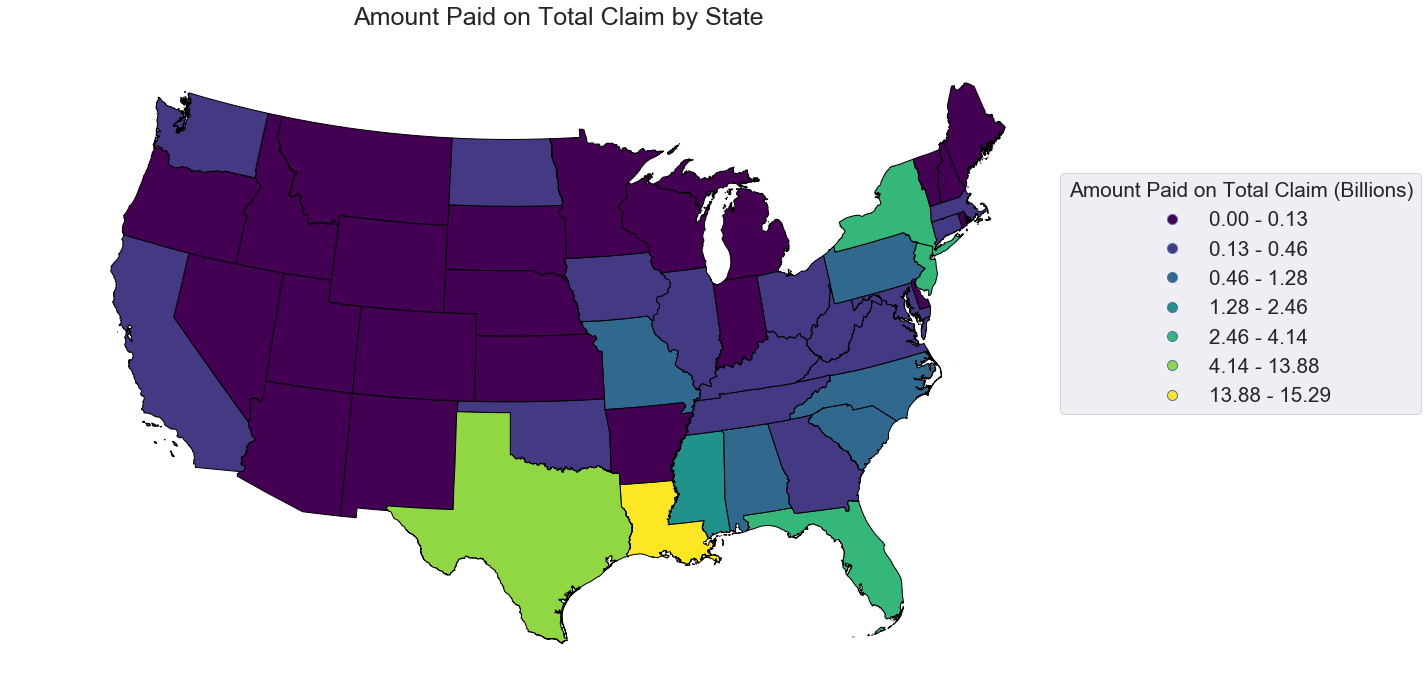

In [384]:
# defining our plot
plt.subplots(figsize=(20,15))
ax = plt.subplot()

nfip_claims_state_map.plot(column="amountpaidontotalclaim-bn", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   legend_kwds={'loc': 'lower left', 'title': 'Amount Paid on Total Claim (Billions)', 
                   'title_fontsize': 'xx-large','fontsize': 'xx-large', 'bbox_to_anchor': (1, 0.4)},
                   cmap='viridis', edgecolor='black')

ax.set_title("Amount Paid on Total Claim by State", fontsize=25, pad=30)

plt.tight_layout()

plt.axis('off')

#saving figure
plt.savefig('figures/claims-paid-amount-map.png')

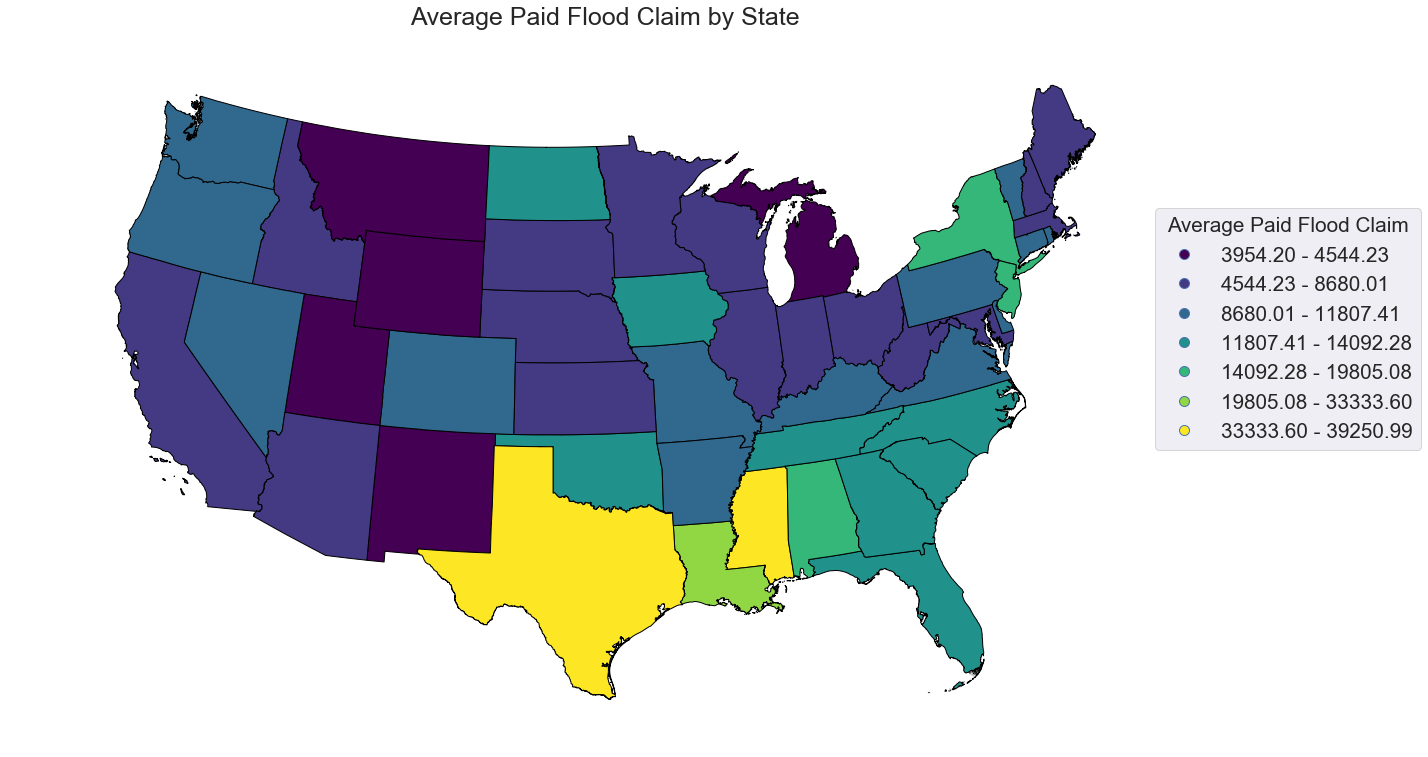

In [385]:
# defining our plot
plt.subplots(figsize=(20,15))
ax = plt.subplot()

nfip_claims_state_map.plot(column="average_paid_flood_claim", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   legend_kwds={'loc': 'lower left', 'title': 'Average Paid Flood Claim', 
                   'title_fontsize': 'xx-large','fontsize': 'xx-large', 'bbox_to_anchor': (1, 0.4)},
                   cmap='viridis', edgecolor='black')

ax.set_title("Average Paid Flood Claim by State", fontsize=25, pad=30)

plt.tight_layout()

plt.axis('off')

#saving figure
plt.savefig('figures/claims-paid-amount-average-map.png')

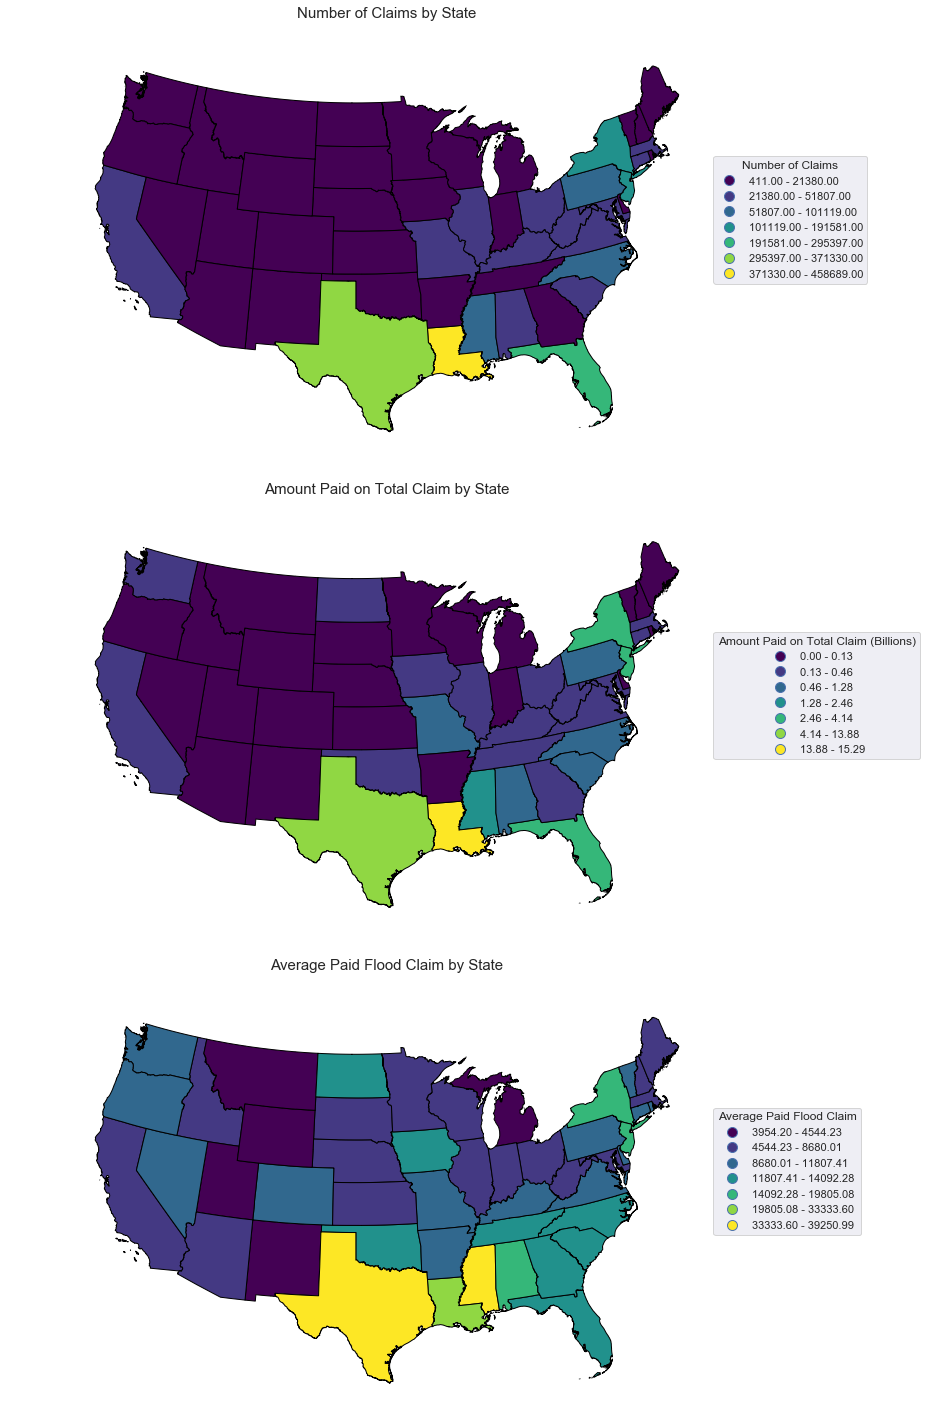

In [382]:
sns.set(font_scale=1)
fig = pl.figure(figsize=(20,20))

# adding first subplot
ax = fig.add_subplot(311)

nfip_claims_state_map.plot(column="claimscount", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   cmap='viridis', edgecolor='black', legend_kwds={'loc': 'lower left', 
                   'title': 'Number of Claims', 'bbox_to_anchor': (1, 0.4)})

ax.set_title("Number of Claims by State", fontsize=15, pad=30)
plt.axis('off')

# adding second subplot
ax = fig.add_subplot(312)

nfip_claims_state_map.plot(column="amountpaidontotalclaim-bn", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   cmap='viridis', edgecolor='black', legend_kwds={'loc': 'lower left', 
                   'title': 'Amount Paid on Total Claim (Billions)', 'bbox_to_anchor': (1, 0.4)})

ax.set_title("Amount Paid on Total Claim by State", fontsize=15, pad=30)
plt.axis('off')


# adding third subplot
ax = fig.add_subplot(313)

nfip_claims_state_map.plot(column="average_paid_flood_claim", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   cmap='viridis', edgecolor='black', legend_kwds={'loc': 'lower left', 
                   'title': 'Average Paid Flood Claim', 'bbox_to_anchor': (1, 0.4)})

ax.set_title("Average Paid Flood Claim by State", fontsize=15, pad=30)
plt.axis('off')

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-maps.png')